#### Project 1 in Physics analysis
## DNN for classification of points

In [9]:
#Importing necessary packages
import numpy as np
import os
from keras import layers
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras import losses
from keras import metrics
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
plt.rcParams['font.size']= 14

### Generating data
The task is to classify the points of a grid, determining wether they are located within a triangle or not. The correct classification of the data is given by running the points through the non-linear function given in lecture. As we are only using the labels 0 and 1, this is a simple example of binary classification.

To generate data to train our network, we create arrays with random points within the interval $[-50,50]$, and create labels for them by using the non-linear function. Hence, there is really no limit to the amount of samples we have available for our problem. However, often in more realistic machine-learning problems, one of the real challenges is managing to detect a pattern within a limited amount of data. Hence, one should always investigate how to tweak the network-model in order to obtain better results without assuming an endless amount of data. Using too much data to train the network may also yield overtraining, so more data of the same kind is not necessarily always the best case.

In the following tasks, it has as a first approach been investigated how much the amount of training data affects the performance of the DNN-model, by studying the convergence of the loss function. Augmented samples is also a way of trying to artificially generate more samples by adding noise to the data available, and is hence an apporach that should be considered as well. 

(Studying the network's progress in accuracy thorugh the amount of epochs needed to converge the loss-function, gives us an insight in the balance between how much data is sufficient to build a good model.)

In [13]:
#GENERATING DATA

# size of each sample
L=2
# box size
B=100

#Data in folder different from the code, check this line
!mkdir DATA

A subdirectory or file DATA already exists.


In [2]:
%run nonlinear_function.py #Function downloaded from drive, function with triangle; blue zero, yellow one

TYPE=1

# random seed for reproducibility
np.random.seed(12345)
print(np.random.randint(0,10),np.random.randint(0,10),np.random.randint(0,10))

#Generate an arrray of length N of dim (N,2) with random numbers in the interval [0,1),
#subtracting 0.5 and multiplying with 100 moves the numbers to the interval [-50,50]

#function for labeling the generated samples
def set_label(N,x,y):
    for i in range(N):
    # label data according to a nonlinear function "f"
        y[i] = f(x[i],TYPE)
    return y

def generate_data(num_samples, label_func = set_label):
    x_arr,y_arr = (np.random.random((num_samples,2))-0.5)*B, np.zeros((num_samples,1))
    y_arr = set_label(num_samples,x_arr,y_arr)
    return x_arr, y_arr

def plot_scatter(x,y):
    plt.figure(figsize = (8,8))
    plt.scatter(x[:,0],x[:,1],c=y)
    plt.show()

def save_in_DATA(x,y,name_x, name_y, func=filename,TYPE=1):
    np.savetxt(func(name_x,TYPE),x)
    np.savetxt(func(name_y,TYPE),y,fmt="%d")

def Rescale(x):
    #Return (x-x.mean())/
    return x/50

def load_data(name):
    x = np.loadtxt(filename(str("data_"+name),TYPE), delimiter=' ')
    y = np.loadtxt(filename(str("labels_"+name),TYPE), delimiter=' ')
    return x,y

2 5 1


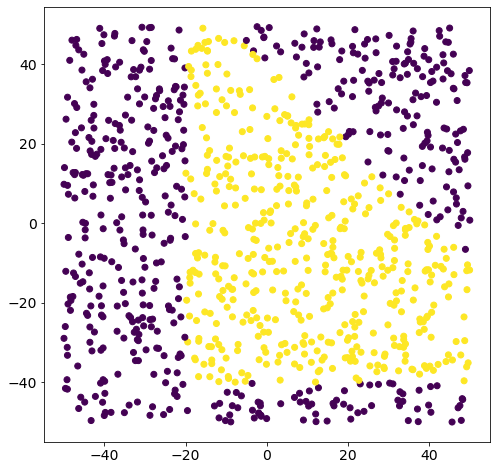

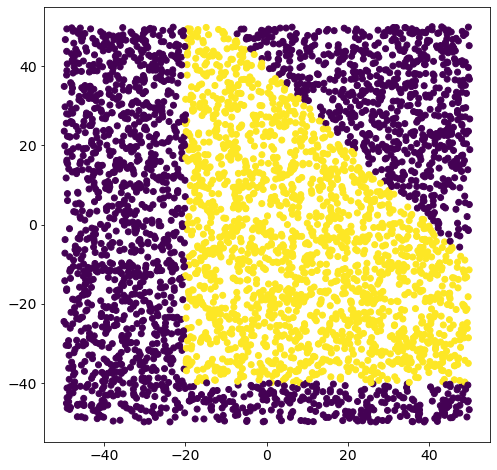

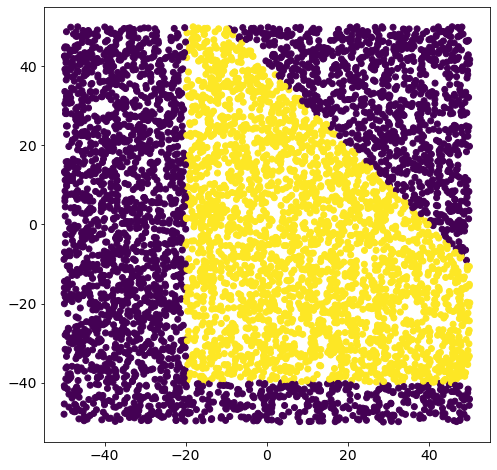

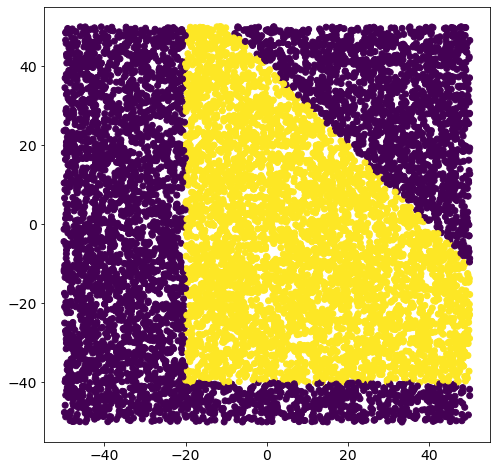

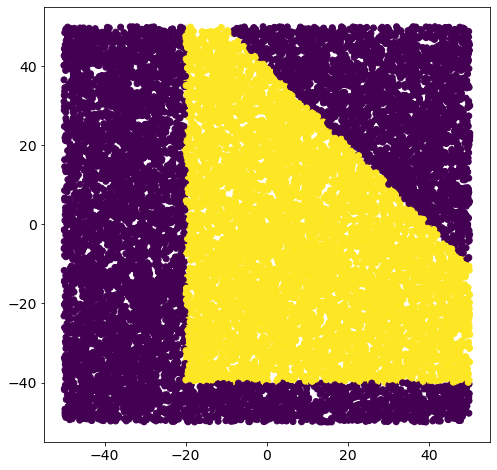

In [7]:
#Generate different amounts of data to see how many epochs is needed for each case
Num_samples = [1000,4000,6000,10000,15000]
nums = ["1k","4k","6k","10k","15k"]

for i in range(len(nums)):
    name_x,name_y = str("x_"+nums[i]),str("y_"+nums[i])
    x_gen,y_gen = generate_data(Num_samples[i])
    plot_scatter(x_gen, y_gen)
    save_in_DATA(x_gen,y_gen,str("data_"+nums[i]),str("labels_"+nums[i]))

In [328]:
#Defining model, explicit example
np.random.seed(12345)

CASE=1

#Dense - connecting every point in this layer into next layer
#Choosing relu for th first layer
if CASE==1:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation ='relu'))
    model.add(Dense(20,activation = 'relu')) #second layer, 20 nodes, with relu activation
    model.add(Dense(20,activation = 'relu'))
    model.add(Dropout(0.2)) #make the model more stochastic,drop nodes with prob. 0.2 for each layer
    model.add(Dense(1,activation='sigmoid')) #adds a single node, with func 0,1 -> use sigmoid here
    #nepoch=600 #Full training, going through the database 400 times, Keras reshuffles the data betw. each time
    
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 2)                 6         
                                                                 
 dense_49 (Dense)            (None, 20)                60        
                                                                 
 dense_50 (Dense)            (None, 20)                420       
                                                                 
 dropout_12 (Dropout)        (None, 20)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
def create_model(L,hidden_layers,activation_func,drop_out, init_al):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation = activation_func))
    for i in range(hidden_layers):
        model.add(Dense(20,activation = activation_func,kernel_initializer=init_al))
    model.add(Dropout(drop_out))
    model.add(Dense(1,activation = 'sigmoid'))
    return model

def compile_model(L=2,hidden_layers=2,activation_func='relu',drop_out=0.2,opti='adam',init_al='glorot_uniform', create = create_model):
    #create the model
    model=create(L,hidden_layers,activation_func,drop_out,init_al)
    # compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=opti,
                  metrics=['accuracy'])
    
    return model

es = EarlyStopping(monitor='val_loss',min_delta = 0.00001, mode='min', patience =8)

In [4]:
def train_fits(num_samples,perc,L_dim,nepochs,init_weights):
    fits = []
    es = EarlyStopping(monitor='val_loss',min_delta = 0.00001, mode='min', patience =8)
    for i in range(len(num_samples)):
        N = num_samples[i]
        N_train = int(N*perc)
        print(N_train)
        x,y = generate_data(N)
        print(x[0:10])
        #save_in_DATA(x_data,y_data,str("x_"+names[i]),str("y_"+names[i]))
        x_train = x[0:N_train]
        y_train = y[0:N_train]
        x_valid = x[N_train:]
        y_valid = y[N_train:]
        x_train, x_valid = Rescale(x_train),Rescale(x_valid)
        model.load_weights(init_weights)
        fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
        fits.append(fit)
    return fits

In [5]:
def plot_fits(fits,names,cols):
    fig,AX = plt.subplots(1,2,figsize=(14,6.))
    AX[0].set_xlabel('epoch')
    AX[0].set_ylabel("Accuracy")
    AX[1].set_xlabel('epoch')
    AX[1].set_ylabel("Loss")

    for i in range(len(fits)):
        AX[0].plot(fits[i].history['accuracy'], label=str("train_"+names[i]), color = cols[i])
        AX[0].plot(fits[i].history['val_accuracy'], linestyle = '--',label = str("valid_" + names[i]),color = cols[i])
        AX[1].plot(fits[i].history['loss'], label=str("train_"+names[i]), color = cols[i])
        AX[1].plot(fits[i].history['val_loss'], linestyle = '--', label = str("valid_"+names[i]), color = cols[i])
    AX[0].legend()
    AX[1].legend()
    plt.show()

In [33]:
def avg_test(num_samp,rounds,perc,L_dim,nepochs,initializer_func,activation='relu'):
    x,y = generate_data(num_samp)
    x_train = x[0:N_train]
    y_train = y[0:N_train]
    x_valid = x[N_train:]
    y_valid = y[N_train:]
    x_train, x_valid = Rescale(x_train),Rescale(x_valid)

    fits_type = []

    for i in range(rounds):
        model = compile_model(L_dim,2,activation,0.2,'adam',initializer_func)
        fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
        fits_type.append(fit)
    return fits_type

In [53]:
#model = create_model(L_dim,2,'relu',0.2)

#model.compile(loss='binary_crossentropy',#optimizer='RMSprop',
              #optimizer='adam',
            # metrics =['accuracy'])
model = compile_model(L_dim,2,'relu',0.2,'adam')
model.save_weights('initial_weights.h5')

In [70]:
np.random.seed(12345)

num_samples = [1000,4000,6000,10000,15000]
names = ['1k','4k','6k','10k','15k']
cols = ['blue','orange','purple','grey','yellow']

perc = 0.8
L_dim = 2
nepochs = 400

es = EarlyStopping(monitor='val_loss',min_delta = 0.00001, mode='min', patience =8)
fits = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights.h5')

800
[[ 42.96160928 -18.36244454]
 [-31.60811883 -29.54397214]
 [  6.77250291   9.5544703 ]
 [ 46.45145197  15.31770969]
 [ 24.89066375  15.35698709]
 [ 24.77148093  46.13067361]
 [-49.16117021 -39.35556233]
 [-20.12962862  15.64111831]
 [ 30.98125525  37.21759137]
 [ 46.46475974  22.36853469]]
Epoch 1/400
16/16 - 0s - loss: 0.6871 - accuracy: 0.5925 - val_loss: 0.6857 - val_accuracy: 0.4700 - 61ms/epoch - 4ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6687 - accuracy: 0.5800 - val_loss: 0.6781 - val_accuracy: 0.4900 - 42ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6550 - accuracy: 0.6200 - val_loss: 0.6696 - val_accuracy: 0.5350 - 39ms/epoch - 2ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6485 - accuracy: 0.6425 - val_loss: 0.6583 - val_accuracy: 0.5700 - 50ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6401 - accuracy: 0.6650 - val_loss: 0.6502 - val_accuracy: 0.5950 - 50ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6319 - accuracy: 0.6787 - val_loss: 0.6388 - val_accuracy

Epoch 65/400
16/16 - 0s - loss: 0.4872 - accuracy: 0.7887 - val_loss: 0.4999 - val_accuracy: 0.7650 - 43ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.4922 - accuracy: 0.7837 - val_loss: 0.4990 - val_accuracy: 0.7650 - 45ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.4875 - accuracy: 0.7875 - val_loss: 0.5007 - val_accuracy: 0.7600 - 48ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.4864 - accuracy: 0.7750 - val_loss: 0.4997 - val_accuracy: 0.7600 - 49ms/epoch - 3ms/step
Epoch 69/400
16/16 - 0s - loss: 0.4934 - accuracy: 0.7738 - val_loss: 0.4972 - val_accuracy: 0.7600 - 53ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.4900 - accuracy: 0.7775 - val_loss: 0.4947 - val_accuracy: 0.7700 - 42ms/epoch - 3ms/step
Epoch 71/400
16/16 - 0s - loss: 0.4904 - accuracy: 0.7738 - val_loss: 0.4976 - val_accuracy: 0.7600 - 45ms/epoch - 3ms/step
Epoch 72/400
16/16 - 0s - loss: 0.4914 - accuracy: 0.7788 - val_loss: 0.4936 - val_accuracy: 0.7600 - 46ms/epoch - 3ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.4339 - accuracy: 0.8012 - val_loss: 0.4377 - val_accuracy: 0.7850 - 44ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.4159 - accuracy: 0.8138 - val_loss: 0.4354 - val_accuracy: 0.7800 - 41ms/epoch - 3ms/step
Epoch 133/400
16/16 - 0s - loss: 0.4253 - accuracy: 0.8050 - val_loss: 0.4398 - val_accuracy: 0.7750 - 42ms/epoch - 3ms/step
Epoch 134/400
16/16 - 0s - loss: 0.4295 - accuracy: 0.8087 - val_loss: 0.4349 - val_accuracy: 0.7800 - 38ms/epoch - 2ms/step
Epoch 135/400
16/16 - 0s - loss: 0.4163 - accuracy: 0.8175 - val_loss: 0.4332 - val_accuracy: 0.7850 - 44ms/epoch - 3ms/step
Epoch 136/400
16/16 - 0s - loss: 0.4308 - accuracy: 0.8100 - val_loss: 0.4341 - val_accuracy: 0.7800 - 37ms/epoch - 2ms/step
Epoch 137/400
16/16 - 0s - loss: 0.4247 - accuracy: 0.8087 - val_loss: 0.4310 - val_accuracy: 0.7850 - 40ms/epoch - 2ms/step
Epoch 138/400
16/16 - 0s - loss: 0.4192 - accuracy: 0.8075 - val_loss: 0.4321 - val_accuracy: 0.7850 - 39ms/epoch - 2ms/step


Epoch 197/400
16/16 - 0s - loss: 0.3794 - accuracy: 0.8313 - val_loss: 0.4005 - val_accuracy: 0.8000 - 40ms/epoch - 2ms/step
Epoch 198/400
16/16 - 0s - loss: 0.3833 - accuracy: 0.8250 - val_loss: 0.3990 - val_accuracy: 0.8000 - 38ms/epoch - 2ms/step
Epoch 199/400
16/16 - 0s - loss: 0.3894 - accuracy: 0.8313 - val_loss: 0.3958 - val_accuracy: 0.8050 - 38ms/epoch - 2ms/step
Epoch 200/400
16/16 - 0s - loss: 0.3837 - accuracy: 0.8325 - val_loss: 0.3997 - val_accuracy: 0.8000 - 39ms/epoch - 2ms/step
Epoch 201/400
16/16 - 0s - loss: 0.3852 - accuracy: 0.8313 - val_loss: 0.3984 - val_accuracy: 0.8000 - 40ms/epoch - 3ms/step
Epoch 202/400
16/16 - 0s - loss: 0.3812 - accuracy: 0.8338 - val_loss: 0.3950 - val_accuracy: 0.8000 - 42ms/epoch - 3ms/step
Epoch 203/400
16/16 - 0s - loss: 0.3793 - accuracy: 0.8400 - val_loss: 0.3961 - val_accuracy: 0.7950 - 39ms/epoch - 2ms/step
Epoch 204/400
16/16 - 0s - loss: 0.3731 - accuracy: 0.8388 - val_loss: 0.3991 - val_accuracy: 0.7950 - 41ms/epoch - 3ms/step


Epoch 263/400
16/16 - 0s - loss: 0.3450 - accuracy: 0.8550 - val_loss: 0.3622 - val_accuracy: 0.8200 - 39ms/epoch - 2ms/step
Epoch 264/400
16/16 - 0s - loss: 0.3500 - accuracy: 0.8550 - val_loss: 0.3616 - val_accuracy: 0.8200 - 41ms/epoch - 3ms/step
Epoch 265/400
16/16 - 0s - loss: 0.3579 - accuracy: 0.8462 - val_loss: 0.3598 - val_accuracy: 0.8300 - 36ms/epoch - 2ms/step
Epoch 266/400
16/16 - 0s - loss: 0.3395 - accuracy: 0.8600 - val_loss: 0.3622 - val_accuracy: 0.8200 - 42ms/epoch - 3ms/step
Epoch 267/400
16/16 - 0s - loss: 0.3387 - accuracy: 0.8612 - val_loss: 0.3591 - val_accuracy: 0.8300 - 39ms/epoch - 2ms/step
Epoch 268/400
16/16 - 0s - loss: 0.3346 - accuracy: 0.8512 - val_loss: 0.3600 - val_accuracy: 0.8300 - 42ms/epoch - 3ms/step
Epoch 269/400
16/16 - 0s - loss: 0.3424 - accuracy: 0.8512 - val_loss: 0.3609 - val_accuracy: 0.8250 - 37ms/epoch - 2ms/step
Epoch 270/400
16/16 - 0s - loss: 0.3431 - accuracy: 0.8512 - val_loss: 0.3595 - val_accuracy: 0.8250 - 42ms/epoch - 3ms/step


Epoch 329/400
16/16 - 0s - loss: 0.2725 - accuracy: 0.8963 - val_loss: 0.2704 - val_accuracy: 0.9000 - 41ms/epoch - 3ms/step
Epoch 330/400
16/16 - 0s - loss: 0.2727 - accuracy: 0.8938 - val_loss: 0.2671 - val_accuracy: 0.9000 - 41ms/epoch - 3ms/step
Epoch 331/400
16/16 - 0s - loss: 0.2669 - accuracy: 0.8950 - val_loss: 0.2625 - val_accuracy: 0.9200 - 41ms/epoch - 3ms/step
Epoch 332/400
16/16 - 0s - loss: 0.2738 - accuracy: 0.8925 - val_loss: 0.2610 - val_accuracy: 0.9150 - 40ms/epoch - 2ms/step
Epoch 333/400
16/16 - 0s - loss: 0.2624 - accuracy: 0.9000 - val_loss: 0.2617 - val_accuracy: 0.9150 - 39ms/epoch - 2ms/step
Epoch 334/400
16/16 - 0s - loss: 0.2692 - accuracy: 0.8950 - val_loss: 0.2565 - val_accuracy: 0.9200 - 37ms/epoch - 2ms/step
Epoch 335/400
16/16 - 0s - loss: 0.2540 - accuracy: 0.9087 - val_loss: 0.2551 - val_accuracy: 0.9150 - 40ms/epoch - 2ms/step
Epoch 336/400
16/16 - 0s - loss: 0.2629 - accuracy: 0.9062 - val_loss: 0.2548 - val_accuracy: 0.9100 - 39ms/epoch - 2ms/step


Epoch 395/400
16/16 - 0s - loss: 0.1739 - accuracy: 0.9362 - val_loss: 0.1414 - val_accuracy: 0.9550 - 43ms/epoch - 3ms/step
Epoch 396/400
16/16 - 0s - loss: 0.1771 - accuracy: 0.9362 - val_loss: 0.1424 - val_accuracy: 0.9600 - 40ms/epoch - 2ms/step
Epoch 397/400
16/16 - 0s - loss: 0.1710 - accuracy: 0.9362 - val_loss: 0.1433 - val_accuracy: 0.9650 - 42ms/epoch - 3ms/step
Epoch 398/400
16/16 - 0s - loss: 0.1766 - accuracy: 0.9325 - val_loss: 0.1422 - val_accuracy: 0.9600 - 38ms/epoch - 2ms/step
Epoch 399/400
16/16 - 0s - loss: 0.1825 - accuracy: 0.9275 - val_loss: 0.1398 - val_accuracy: 0.9550 - 41ms/epoch - 3ms/step
Epoch 400/400
16/16 - 0s - loss: 0.1674 - accuracy: 0.9425 - val_loss: 0.1421 - val_accuracy: 0.9600 - 38ms/epoch - 2ms/step
3200
[[ -1.48297323  -0.07788833]
 [ 31.26450396  47.01071263]
 [ -6.05696442 -26.54622208]
 [ 25.48935466 -13.58798801]
 [ 27.93764153 -17.39482609]
 [ 32.32360633 -10.24444496]
 [  8.60918157  11.89608001]
 [-15.56680871  38.07823316]
 [ 10.9896788

Epoch 59/400
64/64 - 0s - loss: 0.1922 - accuracy: 0.9287 - val_loss: 0.1917 - val_accuracy: 0.9300 - 90ms/epoch - 1ms/step
Epoch 60/400
64/64 - 0s - loss: 0.1909 - accuracy: 0.9312 - val_loss: 0.1884 - val_accuracy: 0.9262 - 90ms/epoch - 1ms/step
Epoch 61/400
64/64 - 0s - loss: 0.1908 - accuracy: 0.9281 - val_loss: 0.1832 - val_accuracy: 0.9312 - 93ms/epoch - 1ms/step
Epoch 62/400
64/64 - 0s - loss: 0.1891 - accuracy: 0.9312 - val_loss: 0.1831 - val_accuracy: 0.9362 - 91ms/epoch - 1ms/step
Epoch 63/400
64/64 - 0s - loss: 0.1885 - accuracy: 0.9303 - val_loss: 0.1823 - val_accuracy: 0.9337 - 91ms/epoch - 1ms/step
Epoch 64/400
64/64 - 0s - loss: 0.1898 - accuracy: 0.9306 - val_loss: 0.1818 - val_accuracy: 0.9337 - 91ms/epoch - 1ms/step
Epoch 65/400
64/64 - 0s - loss: 0.1843 - accuracy: 0.9337 - val_loss: 0.1814 - val_accuracy: 0.9300 - 91ms/epoch - 1ms/step
Epoch 66/400
64/64 - 0s - loss: 0.1889 - accuracy: 0.9291 - val_loss: 0.1891 - val_accuracy: 0.9275 - 90ms/epoch - 1ms/step
Epoch 67

Epoch 125/400
64/64 - 0s - loss: 0.1517 - accuracy: 0.9438 - val_loss: 0.1428 - val_accuracy: 0.9438 - 92ms/epoch - 1ms/step
Epoch 126/400
64/64 - 0s - loss: 0.1480 - accuracy: 0.9456 - val_loss: 0.1420 - val_accuracy: 0.9513 - 93ms/epoch - 1ms/step
Epoch 127/400
64/64 - 0s - loss: 0.1487 - accuracy: 0.9466 - val_loss: 0.1406 - val_accuracy: 0.9475 - 93ms/epoch - 1ms/step
Epoch 128/400
64/64 - 0s - loss: 0.1505 - accuracy: 0.9447 - val_loss: 0.1394 - val_accuracy: 0.9613 - 91ms/epoch - 1ms/step
Epoch 129/400
64/64 - 0s - loss: 0.1500 - accuracy: 0.9463 - val_loss: 0.1597 - val_accuracy: 0.9250 - 94ms/epoch - 1ms/step
Epoch 130/400
64/64 - 0s - loss: 0.1503 - accuracy: 0.9409 - val_loss: 0.1381 - val_accuracy: 0.9588 - 91ms/epoch - 1ms/step
Epoch 131/400
64/64 - 0s - loss: 0.1445 - accuracy: 0.9475 - val_loss: 0.1439 - val_accuracy: 0.9362 - 90ms/epoch - 1ms/step
Epoch 132/400
64/64 - 0s - loss: 0.1458 - accuracy: 0.9466 - val_loss: 0.1389 - val_accuracy: 0.9513 - 90ms/epoch - 1ms/step


Epoch 191/400
64/64 - 0s - loss: 0.1267 - accuracy: 0.9534 - val_loss: 0.1214 - val_accuracy: 0.9588 - 92ms/epoch - 1ms/step
Epoch 192/400
64/64 - 0s - loss: 0.1232 - accuracy: 0.9531 - val_loss: 0.1085 - val_accuracy: 0.9663 - 90ms/epoch - 1ms/step
Epoch 193/400
64/64 - 0s - loss: 0.1203 - accuracy: 0.9550 - val_loss: 0.1108 - val_accuracy: 0.9650 - 97ms/epoch - 2ms/step
Epoch 194/400
64/64 - 0s - loss: 0.1223 - accuracy: 0.9538 - val_loss: 0.1173 - val_accuracy: 0.9613 - 94ms/epoch - 1ms/step
Epoch 195/400
64/64 - 0s - loss: 0.1194 - accuracy: 0.9563 - val_loss: 0.1133 - val_accuracy: 0.9625 - 90ms/epoch - 1ms/step
Epoch 196/400
64/64 - 0s - loss: 0.1247 - accuracy: 0.9547 - val_loss: 0.1104 - val_accuracy: 0.9625 - 92ms/epoch - 1ms/step
Epoch 197/400
64/64 - 0s - loss: 0.1212 - accuracy: 0.9563 - val_loss: 0.1083 - val_accuracy: 0.9700 - 91ms/epoch - 1ms/step
Epoch 198/400
64/64 - 0s - loss: 0.1256 - accuracy: 0.9522 - val_loss: 0.1219 - val_accuracy: 0.9538 - 93ms/epoch - 1ms/step


Epoch 26/400
96/96 - 0s - loss: 0.1747 - accuracy: 0.9317 - val_loss: 0.1859 - val_accuracy: 0.9208 - 124ms/epoch - 1ms/step
Epoch 27/400
96/96 - 0s - loss: 0.1703 - accuracy: 0.9346 - val_loss: 0.1829 - val_accuracy: 0.9217 - 126ms/epoch - 1ms/step
Epoch 28/400
96/96 - 0s - loss: 0.1675 - accuracy: 0.9315 - val_loss: 0.1818 - val_accuracy: 0.9225 - 124ms/epoch - 1ms/step
Epoch 29/400
96/96 - 0s - loss: 0.1658 - accuracy: 0.9344 - val_loss: 0.1783 - val_accuracy: 0.9308 - 123ms/epoch - 1ms/step
Epoch 30/400
96/96 - 0s - loss: 0.1636 - accuracy: 0.9358 - val_loss: 0.1789 - val_accuracy: 0.9292 - 131ms/epoch - 1ms/step
Epoch 31/400
96/96 - 0s - loss: 0.1624 - accuracy: 0.9346 - val_loss: 0.1800 - val_accuracy: 0.9233 - 126ms/epoch - 1ms/step
Epoch 32/400
96/96 - 0s - loss: 0.1620 - accuracy: 0.9365 - val_loss: 0.1746 - val_accuracy: 0.9342 - 125ms/epoch - 1ms/step
Epoch 33/400
96/96 - 0s - loss: 0.1608 - accuracy: 0.9396 - val_loss: 0.1750 - val_accuracy: 0.9292 - 124ms/epoch - 1ms/step


Epoch 92/400
96/96 - 0s - loss: 0.0709 - accuracy: 0.9712 - val_loss: 0.0678 - val_accuracy: 0.9775 - 167ms/epoch - 2ms/step
Epoch 93/400
96/96 - 0s - loss: 0.0699 - accuracy: 0.9729 - val_loss: 0.0734 - val_accuracy: 0.9708 - 133ms/epoch - 1ms/step
Epoch 94/400
96/96 - 0s - loss: 0.0694 - accuracy: 0.9719 - val_loss: 0.0638 - val_accuracy: 0.9808 - 131ms/epoch - 1ms/step
Epoch 95/400
96/96 - 0s - loss: 0.0631 - accuracy: 0.9777 - val_loss: 0.0623 - val_accuracy: 0.9792 - 157ms/epoch - 2ms/step
Epoch 96/400
96/96 - 0s - loss: 0.0651 - accuracy: 0.9729 - val_loss: 0.0618 - val_accuracy: 0.9808 - 156ms/epoch - 2ms/step
Epoch 97/400
96/96 - 0s - loss: 0.0659 - accuracy: 0.9725 - val_loss: 0.0582 - val_accuracy: 0.9842 - 148ms/epoch - 2ms/step
Epoch 98/400
96/96 - 0s - loss: 0.0629 - accuracy: 0.9742 - val_loss: 0.0593 - val_accuracy: 0.9817 - 139ms/epoch - 1ms/step
Epoch 99/400
96/96 - 0s - loss: 0.0615 - accuracy: 0.9754 - val_loss: 0.0549 - val_accuracy: 0.9842 - 135ms/epoch - 1ms/step


KeyboardInterrupt: 

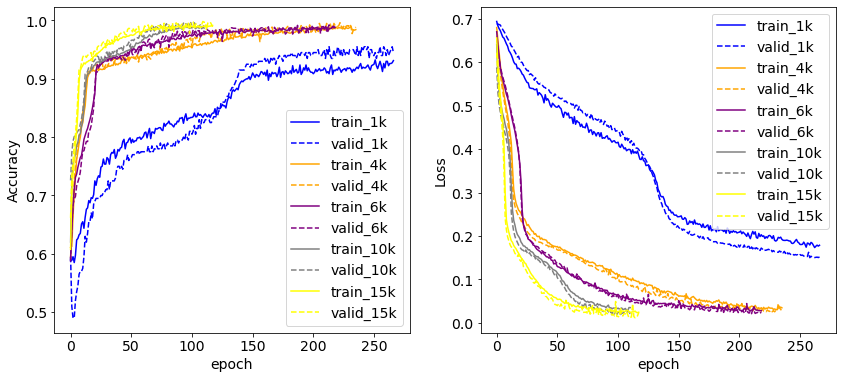

In [61]:
#Plot result
plot_fits(fits,names)

From the plot above, we can see that even a sample size of 4k samples, yields about the same loss and accuracy as the sample size of 15k samples, if the data is fed through the learning algorithm more rounds. (insert Christoffers plot over different averaged accuracies for the different samples-sizes). Hence, it is not necessary to have a very large amount of samples when investigating the properties of the classifier further.

In the grid search, we must investigate what hyperparameters of the model that may improve it in terms of accuracy and computation time. For a sample size of 4k samples, that means that the best prediction gives a competitive accuracy with the least number of epochs.

In [90]:
#Investigate different kind of initial weights
#Have only initialized the hidden layers, as the first layer only has two weights
#Different initializations possible:

#randomnormal
model = compile_model(L_dim,2,'relu',0.2,'adam','random_normal')
model.save_weights('initial_weights_1.h5')

fits1 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_1.h5')

800
[[ 19.17587003  10.81567708]
 [-31.53022374  16.21066249]
 [ -9.93636096  -4.41645028]
 [ 22.05562262 -32.07451396]
 [-44.03997795  30.90275278]
 [ 43.03517877   5.97471114]
 [  2.21809581 -33.27193076]
 [ 15.72439606 -35.31442231]
 [-46.98882338 -11.42032235]
 [-46.25010571 -40.67030615]]
Epoch 1/400
16/16 - 1s - loss: 0.6914 - accuracy: 0.6363 - val_loss: 0.6899 - val_accuracy: 0.6850 - 618ms/epoch - 39ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6889 - accuracy: 0.6513 - val_loss: 0.6866 - val_accuracy: 0.6850 - 38ms/epoch - 2ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6849 - accuracy: 0.6650 - val_loss: 0.6823 - val_accuracy: 0.6950 - 46ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6790 - accuracy: 0.6575 - val_loss: 0.6754 - val_accuracy: 0.6950 - 47ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6711 - accuracy: 0.6575 - val_loss: 0.6660 - val_accuracy: 0.6900 - 50ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6597 - accuracy: 0.6662 - val_loss: 0.6547 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.3191 - accuracy: 0.8838 - val_loss: 0.3224 - val_accuracy: 0.8800 - 39ms/epoch - 2ms/step
Epoch 66/400
16/16 - 0s - loss: 0.3082 - accuracy: 0.8925 - val_loss: 0.3107 - val_accuracy: 0.8750 - 37ms/epoch - 2ms/step
Epoch 67/400
16/16 - 0s - loss: 0.3011 - accuracy: 0.8975 - val_loss: 0.3025 - val_accuracy: 0.8950 - 37ms/epoch - 2ms/step
Epoch 68/400
16/16 - 0s - loss: 0.2904 - accuracy: 0.9100 - val_loss: 0.2931 - val_accuracy: 0.9000 - 38ms/epoch - 2ms/step
Epoch 69/400
16/16 - 0s - loss: 0.2836 - accuracy: 0.9112 - val_loss: 0.2897 - val_accuracy: 0.9050 - 37ms/epoch - 2ms/step
Epoch 70/400
16/16 - 0s - loss: 0.2708 - accuracy: 0.9162 - val_loss: 0.2832 - val_accuracy: 0.9150 - 37ms/epoch - 2ms/step
Epoch 71/400
16/16 - 0s - loss: 0.2633 - accuracy: 0.9175 - val_loss: 0.2784 - val_accuracy: 0.9050 - 38ms/epoch - 2ms/step
Epoch 72/400
16/16 - 0s - loss: 0.2598 - accuracy: 0.9225 - val_loss: 0.2757 - val_accuracy: 0.9200 - 37ms/epoch - 2ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.1638 - accuracy: 0.9400 - val_loss: 0.1886 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.1667 - accuracy: 0.9413 - val_loss: 0.1880 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 133/400
16/16 - 0s - loss: 0.1638 - accuracy: 0.9375 - val_loss: 0.1887 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 134/400
16/16 - 0s - loss: 0.1619 - accuracy: 0.9400 - val_loss: 0.1863 - val_accuracy: 0.9300 - 42ms/epoch - 3ms/step
Epoch 135/400
16/16 - 0s - loss: 0.1566 - accuracy: 0.9438 - val_loss: 0.1844 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 136/400
16/16 - 0s - loss: 0.1615 - accuracy: 0.9362 - val_loss: 0.1822 - val_accuracy: 0.9300 - 38ms/epoch - 2ms/step
Epoch 137/400
16/16 - 0s - loss: 0.1593 - accuracy: 0.9438 - val_loss: 0.1813 - val_accuracy: 0.9300 - 39ms/epoch - 2ms/step
Epoch 138/400
16/16 - 0s - loss: 0.1573 - accuracy: 0.9425 - val_loss: 0.1826 - val_accuracy: 0.9300 - 40ms/epoch - 3ms/step


Epoch 197/400
16/16 - 0s - loss: 0.1234 - accuracy: 0.9588 - val_loss: 0.1505 - val_accuracy: 0.9550 - 39ms/epoch - 2ms/step
Epoch 198/400
16/16 - 0s - loss: 0.1222 - accuracy: 0.9625 - val_loss: 0.1500 - val_accuracy: 0.9500 - 37ms/epoch - 2ms/step
Epoch 199/400
16/16 - 0s - loss: 0.1229 - accuracy: 0.9538 - val_loss: 0.1515 - val_accuracy: 0.9450 - 40ms/epoch - 3ms/step
Epoch 200/400
16/16 - 0s - loss: 0.1183 - accuracy: 0.9613 - val_loss: 0.1469 - val_accuracy: 0.9550 - 39ms/epoch - 2ms/step
Epoch 201/400
16/16 - 0s - loss: 0.1243 - accuracy: 0.9550 - val_loss: 0.1465 - val_accuracy: 0.9550 - 39ms/epoch - 2ms/step
Epoch 202/400
16/16 - 0s - loss: 0.1228 - accuracy: 0.9625 - val_loss: 0.1500 - val_accuracy: 0.9500 - 40ms/epoch - 3ms/step
Epoch 203/400
16/16 - 0s - loss: 0.1234 - accuracy: 0.9588 - val_loss: 0.1479 - val_accuracy: 0.9550 - 40ms/epoch - 3ms/step
Epoch 204/400
16/16 - 0s - loss: 0.1259 - accuracy: 0.9550 - val_loss: 0.1492 - val_accuracy: 0.9650 - 38ms/epoch - 2ms/step


Epoch 13/400
64/64 - 0s - loss: 0.5063 - accuracy: 0.7116 - val_loss: 0.5155 - val_accuracy: 0.7013 - 91ms/epoch - 1ms/step
Epoch 14/400
64/64 - 0s - loss: 0.4988 - accuracy: 0.7169 - val_loss: 0.5111 - val_accuracy: 0.7163 - 91ms/epoch - 1ms/step
Epoch 15/400
64/64 - 0s - loss: 0.4945 - accuracy: 0.7163 - val_loss: 0.5026 - val_accuracy: 0.7075 - 90ms/epoch - 1ms/step
Epoch 16/400
64/64 - 0s - loss: 0.4899 - accuracy: 0.7259 - val_loss: 0.4954 - val_accuracy: 0.7100 - 91ms/epoch - 1ms/step
Epoch 17/400
64/64 - 0s - loss: 0.4790 - accuracy: 0.7291 - val_loss: 0.4889 - val_accuracy: 0.7362 - 92ms/epoch - 1ms/step
Epoch 18/400
64/64 - 0s - loss: 0.4762 - accuracy: 0.7275 - val_loss: 0.4824 - val_accuracy: 0.7175 - 87ms/epoch - 1ms/step
Epoch 19/400
64/64 - 0s - loss: 0.4732 - accuracy: 0.7375 - val_loss: 0.4775 - val_accuracy: 0.7425 - 90ms/epoch - 1ms/step
Epoch 20/400
64/64 - 0s - loss: 0.4684 - accuracy: 0.7278 - val_loss: 0.4709 - val_accuracy: 0.7262 - 93ms/epoch - 1ms/step
Epoch 21

64/64 - 0s - loss: 0.2560 - accuracy: 0.8825 - val_loss: 0.2542 - val_accuracy: 0.8763 - 91ms/epoch - 1ms/step
Epoch 80/400
64/64 - 0s - loss: 0.2560 - accuracy: 0.8797 - val_loss: 0.2551 - val_accuracy: 0.8788 - 89ms/epoch - 1ms/step
Epoch 81/400
64/64 - 0s - loss: 0.2563 - accuracy: 0.8797 - val_loss: 0.2523 - val_accuracy: 0.8788 - 90ms/epoch - 1ms/step
Epoch 82/400
64/64 - 0s - loss: 0.2591 - accuracy: 0.8800 - val_loss: 0.2648 - val_accuracy: 0.8712 - 90ms/epoch - 1ms/step
Epoch 83/400
64/64 - 0s - loss: 0.2580 - accuracy: 0.8838 - val_loss: 0.2581 - val_accuracy: 0.8775 - 94ms/epoch - 1ms/step
Epoch 84/400
64/64 - 0s - loss: 0.2596 - accuracy: 0.8778 - val_loss: 0.2628 - val_accuracy: 0.8813 - 89ms/epoch - 1ms/step
Epoch 85/400
64/64 - 0s - loss: 0.2589 - accuracy: 0.8794 - val_loss: 0.2518 - val_accuracy: 0.8763 - 93ms/epoch - 1ms/step
Epoch 86/400
64/64 - 0s - loss: 0.2569 - accuracy: 0.8838 - val_loss: 0.2568 - val_accuracy: 0.8725 - 87ms/epoch - 1ms/step
Epoch 87/400
64/64 - 

Epoch 20/400
96/96 - 0s - loss: 0.4693 - accuracy: 0.7310 - val_loss: 0.4802 - val_accuracy: 0.7050 - 144ms/epoch - 1ms/step
Epoch 21/400
96/96 - 0s - loss: 0.4631 - accuracy: 0.7344 - val_loss: 0.4783 - val_accuracy: 0.7083 - 135ms/epoch - 1ms/step
Epoch 22/400
96/96 - 0s - loss: 0.4616 - accuracy: 0.7300 - val_loss: 0.4729 - val_accuracy: 0.7100 - 126ms/epoch - 1ms/step
Epoch 23/400
96/96 - 0s - loss: 0.4563 - accuracy: 0.7356 - val_loss: 0.4701 - val_accuracy: 0.7075 - 128ms/epoch - 1ms/step
Epoch 24/400
96/96 - 0s - loss: 0.4538 - accuracy: 0.7417 - val_loss: 0.4638 - val_accuracy: 0.7433 - 126ms/epoch - 1ms/step
Epoch 25/400
96/96 - 0s - loss: 0.4478 - accuracy: 0.7444 - val_loss: 0.4583 - val_accuracy: 0.7483 - 125ms/epoch - 1ms/step
Epoch 26/400
96/96 - 0s - loss: 0.4421 - accuracy: 0.7546 - val_loss: 0.4520 - val_accuracy: 0.7558 - 122ms/epoch - 1ms/step
Epoch 27/400
96/96 - 0s - loss: 0.4354 - accuracy: 0.7552 - val_loss: 0.4459 - val_accuracy: 0.7633 - 126ms/epoch - 1ms/step


Epoch 86/400
96/96 - 0s - loss: 0.1358 - accuracy: 0.9471 - val_loss: 0.1385 - val_accuracy: 0.9442 - 118ms/epoch - 1ms/step
Epoch 87/400
96/96 - 0s - loss: 0.1364 - accuracy: 0.9481 - val_loss: 0.1382 - val_accuracy: 0.9467 - 120ms/epoch - 1ms/step
Epoch 88/400
96/96 - 0s - loss: 0.1344 - accuracy: 0.9494 - val_loss: 0.1385 - val_accuracy: 0.9433 - 119ms/epoch - 1ms/step
Epoch 89/400
96/96 - 0s - loss: 0.1341 - accuracy: 0.9475 - val_loss: 0.1390 - val_accuracy: 0.9433 - 121ms/epoch - 1ms/step
Epoch 90/400
96/96 - 0s - loss: 0.1322 - accuracy: 0.9498 - val_loss: 0.1371 - val_accuracy: 0.9442 - 122ms/epoch - 1ms/step
Epoch 91/400
96/96 - 0s - loss: 0.1310 - accuracy: 0.9517 - val_loss: 0.1389 - val_accuracy: 0.9400 - 123ms/epoch - 1ms/step
Epoch 92/400
96/96 - 0s - loss: 0.1301 - accuracy: 0.9508 - val_loss: 0.1338 - val_accuracy: 0.9458 - 123ms/epoch - 1ms/step
Epoch 93/400
96/96 - 0s - loss: 0.1285 - accuracy: 0.9508 - val_loss: 0.1356 - val_accuracy: 0.9408 - 122ms/epoch - 1ms/step


Epoch 152/400
96/96 - 0s - loss: 0.0816 - accuracy: 0.9717 - val_loss: 0.0775 - val_accuracy: 0.9725 - 124ms/epoch - 1ms/step
Epoch 153/400
96/96 - 0s - loss: 0.0799 - accuracy: 0.9698 - val_loss: 0.0819 - val_accuracy: 0.9692 - 126ms/epoch - 1ms/step
Epoch 154/400
96/96 - 0s - loss: 0.0784 - accuracy: 0.9712 - val_loss: 0.0865 - val_accuracy: 0.9633 - 123ms/epoch - 1ms/step
Epoch 155/400
96/96 - 0s - loss: 0.0794 - accuracy: 0.9729 - val_loss: 0.0809 - val_accuracy: 0.9667 - 124ms/epoch - 1ms/step
Epoch 156/400
96/96 - 0s - loss: 0.0756 - accuracy: 0.9717 - val_loss: 0.0804 - val_accuracy: 0.9708 - 124ms/epoch - 1ms/step
Epoch 157/400
96/96 - 0s - loss: 0.0770 - accuracy: 0.9721 - val_loss: 0.0737 - val_accuracy: 0.9717 - 123ms/epoch - 1ms/step
Epoch 158/400
96/96 - 0s - loss: 0.0735 - accuracy: 0.9746 - val_loss: 0.1026 - val_accuracy: 0.9600 - 118ms/epoch - 1ms/step
Epoch 159/400
96/96 - 0s - loss: 0.0775 - accuracy: 0.9721 - val_loss: 0.0855 - val_accuracy: 0.9617 - 125ms/epoch - 1

96/96 - 0s - loss: 0.0378 - accuracy: 0.9873 - val_loss: 0.0357 - val_accuracy: 0.9858 - 148ms/epoch - 2ms/step
Epoch 218/400
96/96 - 0s - loss: 0.0401 - accuracy: 0.9881 - val_loss: 0.0366 - val_accuracy: 0.9917 - 142ms/epoch - 1ms/step
Epoch 219/400
96/96 - 0s - loss: 0.0415 - accuracy: 0.9856 - val_loss: 0.0326 - val_accuracy: 0.9900 - 144ms/epoch - 2ms/step
Epoch 220/400
96/96 - 0s - loss: 0.0372 - accuracy: 0.9856 - val_loss: 0.0427 - val_accuracy: 0.9833 - 133ms/epoch - 1ms/step
Epoch 221/400
96/96 - 0s - loss: 0.0496 - accuracy: 0.9835 - val_loss: 0.0459 - val_accuracy: 0.9825 - 130ms/epoch - 1ms/step
Epoch 222/400
96/96 - 0s - loss: 0.0435 - accuracy: 0.9829 - val_loss: 0.0336 - val_accuracy: 0.9892 - 142ms/epoch - 1ms/step
8000
[[ -8.91216076 -25.66225259]
 [-22.84130329 -12.69747849]
 [  5.43990637 -48.13400296]
 [-12.86168838 -33.79091692]
 [ 42.54857872 -10.00869524]
 [-43.11128059  38.21131512]
 [ 32.10257294 -22.08648745]
 [ 15.48483016   2.2461723 ]
 [-47.66261713 -35.95

Epoch 58/400
160/160 - 0s - loss: 0.1475 - accuracy: 0.9401 - val_loss: 0.1406 - val_accuracy: 0.9505 - 243ms/epoch - 2ms/step
Epoch 59/400
160/160 - 0s - loss: 0.1454 - accuracy: 0.9414 - val_loss: 0.1451 - val_accuracy: 0.9405 - 217ms/epoch - 1ms/step
Epoch 60/400
160/160 - 0s - loss: 0.1408 - accuracy: 0.9433 - val_loss: 0.1365 - val_accuracy: 0.9470 - 206ms/epoch - 1ms/step
Epoch 61/400
160/160 - 0s - loss: 0.1366 - accuracy: 0.9446 - val_loss: 0.1333 - val_accuracy: 0.9480 - 197ms/epoch - 1ms/step
Epoch 62/400
160/160 - 0s - loss: 0.1353 - accuracy: 0.9446 - val_loss: 0.1278 - val_accuracy: 0.9535 - 192ms/epoch - 1ms/step
Epoch 63/400
160/160 - 0s - loss: 0.1328 - accuracy: 0.9473 - val_loss: 0.1239 - val_accuracy: 0.9575 - 197ms/epoch - 1ms/step
Epoch 64/400
160/160 - 0s - loss: 0.1264 - accuracy: 0.9495 - val_loss: 0.1214 - val_accuracy: 0.9555 - 188ms/epoch - 1ms/step
Epoch 65/400
160/160 - 0s - loss: 0.1278 - accuracy: 0.9480 - val_loss: 0.1361 - val_accuracy: 0.9435 - 193ms/e

Epoch 123/400
160/160 - 0s - loss: 0.0475 - accuracy: 0.9809 - val_loss: 0.0343 - val_accuracy: 0.9895 - 251ms/epoch - 2ms/step
Epoch 124/400
160/160 - 0s - loss: 0.0473 - accuracy: 0.9821 - val_loss: 0.0490 - val_accuracy: 0.9785 - 215ms/epoch - 1ms/step
Epoch 125/400
160/160 - 0s - loss: 0.0472 - accuracy: 0.9815 - val_loss: 0.0324 - val_accuracy: 0.9910 - 290ms/epoch - 2ms/step
Epoch 126/400
160/160 - 0s - loss: 0.0478 - accuracy: 0.9815 - val_loss: 0.0335 - val_accuracy: 0.9900 - 240ms/epoch - 2ms/step
Epoch 127/400
160/160 - 0s - loss: 0.0443 - accuracy: 0.9839 - val_loss: 0.0357 - val_accuracy: 0.9860 - 273ms/epoch - 2ms/step
Epoch 128/400
160/160 - 0s - loss: 0.0447 - accuracy: 0.9827 - val_loss: 0.0306 - val_accuracy: 0.9930 - 251ms/epoch - 2ms/step
Epoch 129/400
160/160 - 0s - loss: 0.0428 - accuracy: 0.9856 - val_loss: 0.0356 - val_accuracy: 0.9840 - 241ms/epoch - 2ms/step
Epoch 130/400
160/160 - 0s - loss: 0.0397 - accuracy: 0.9855 - val_loss: 0.0374 - val_accuracy: 0.9865 -

Epoch 27/400
240/240 - 0s - loss: 0.2558 - accuracy: 0.8812 - val_loss: 0.2129 - val_accuracy: 0.8967 - 301ms/epoch - 1ms/step
Epoch 28/400
240/240 - 0s - loss: 0.2254 - accuracy: 0.8954 - val_loss: 0.1864 - val_accuracy: 0.9160 - 277ms/epoch - 1ms/step
Epoch 29/400
240/240 - 0s - loss: 0.2077 - accuracy: 0.9061 - val_loss: 0.1760 - val_accuracy: 0.9263 - 272ms/epoch - 1ms/step
Epoch 30/400
240/240 - 0s - loss: 0.1936 - accuracy: 0.9161 - val_loss: 0.1667 - val_accuracy: 0.9263 - 267ms/epoch - 1ms/step
Epoch 31/400
240/240 - 0s - loss: 0.1900 - accuracy: 0.9158 - val_loss: 0.1603 - val_accuracy: 0.9370 - 280ms/epoch - 1ms/step
Epoch 32/400
240/240 - 0s - loss: 0.1821 - accuracy: 0.9228 - val_loss: 0.1556 - val_accuracy: 0.9410 - 271ms/epoch - 1ms/step
Epoch 33/400
240/240 - 0s - loss: 0.1751 - accuracy: 0.9285 - val_loss: 0.1481 - val_accuracy: 0.9407 - 280ms/epoch - 1ms/step
Epoch 34/400
240/240 - 0s - loss: 0.1693 - accuracy: 0.9302 - val_loss: 0.1441 - val_accuracy: 0.9477 - 322ms/e

Epoch 92/400
240/240 - 0s - loss: 0.0474 - accuracy: 0.9803 - val_loss: 0.0353 - val_accuracy: 0.9867 - 277ms/epoch - 1ms/step
Epoch 93/400
240/240 - 0s - loss: 0.0450 - accuracy: 0.9820 - val_loss: 0.0440 - val_accuracy: 0.9787 - 272ms/epoch - 1ms/step
Epoch 94/400
240/240 - 0s - loss: 0.0448 - accuracy: 0.9817 - val_loss: 0.0620 - val_accuracy: 0.9770 - 277ms/epoch - 1ms/step
Epoch 95/400
240/240 - 0s - loss: 0.0428 - accuracy: 0.9829 - val_loss: 0.0385 - val_accuracy: 0.9800 - 268ms/epoch - 1ms/step
Epoch 96/400
240/240 - 0s - loss: 0.0429 - accuracy: 0.9808 - val_loss: 0.0312 - val_accuracy: 0.9877 - 280ms/epoch - 1ms/step
Epoch 97/400
240/240 - 0s - loss: 0.0414 - accuracy: 0.9848 - val_loss: 0.0332 - val_accuracy: 0.9867 - 267ms/epoch - 1ms/step
Epoch 98/400
240/240 - 0s - loss: 0.0406 - accuracy: 0.9838 - val_loss: 0.0438 - val_accuracy: 0.9797 - 267ms/epoch - 1ms/step
Epoch 99/400
240/240 - 0s - loss: 0.0389 - accuracy: 0.9847 - val_loss: 0.0394 - val_accuracy: 0.9807 - 271ms/e

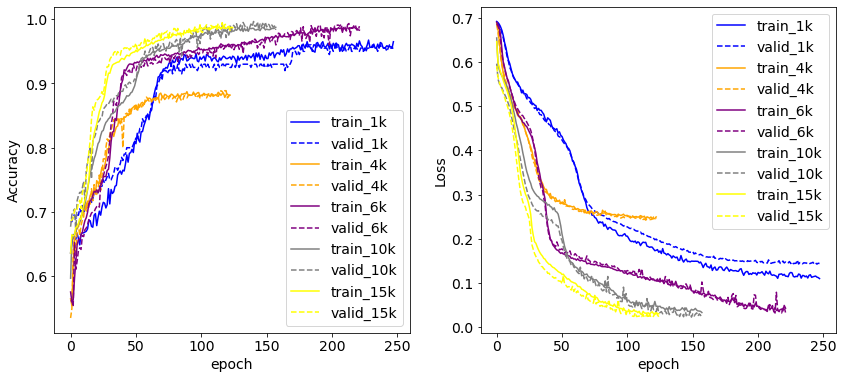

In [91]:
plot_fits(fits1,names,cols)
#Seems to loose 4k on the way
#Converges a lot slower

In [94]:
#TruncatedNormal
#Almost the same as randomUniform, but discards values more than two standard deviations from the mean
init_al_2 = initializers.TruncatedNormal(mean=0., stddev=1.)
model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_2)
model.save_weights('initial_weights_4.h5')

fits2 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_4.h5')

800
[[-29.91795285  38.40322598]
 [ -5.34294928  15.87770731]
 [ 30.48354908  17.46783559]
 [-49.43219886  47.09172827]
 [ -3.71983459 -22.17649978]
 [ 45.87195341   5.49826092]
 [ 41.78308969  -2.71423313]
 [ 20.5615368   19.89926771]
 [  7.3338539   46.67184976]
 [-17.64019783 -27.96940045]]
Epoch 1/400
16/16 - 0s - loss: 0.7804 - accuracy: 0.4338 - val_loss: 0.7378 - val_accuracy: 0.4050 - 469ms/epoch - 29ms/step
Epoch 2/400
16/16 - 0s - loss: 0.7238 - accuracy: 0.4350 - val_loss: 0.7077 - val_accuracy: 0.4050 - 46ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.7022 - accuracy: 0.4512 - val_loss: 0.6883 - val_accuracy: 0.4050 - 47ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6891 - accuracy: 0.4888 - val_loss: 0.6753 - val_accuracy: 0.4150 - 48ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6733 - accuracy: 0.5025 - val_loss: 0.6645 - val_accuracy: 0.4150 - 48ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6706 - accuracy: 0.5600 - val_loss: 0.6526 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.4006 - accuracy: 0.8213 - val_loss: 0.3852 - val_accuracy: 0.8150 - 43ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.4079 - accuracy: 0.8288 - val_loss: 0.3834 - val_accuracy: 0.8100 - 43ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.4049 - accuracy: 0.8263 - val_loss: 0.3793 - val_accuracy: 0.8150 - 43ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.3967 - accuracy: 0.8238 - val_loss: 0.3760 - val_accuracy: 0.8200 - 44ms/epoch - 3ms/step
Epoch 69/400
16/16 - 0s - loss: 0.4002 - accuracy: 0.8300 - val_loss: 0.3742 - val_accuracy: 0.8100 - 42ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.3886 - accuracy: 0.8325 - val_loss: 0.3719 - val_accuracy: 0.8150 - 47ms/epoch - 3ms/step
Epoch 71/400
16/16 - 0s - loss: 0.3843 - accuracy: 0.8313 - val_loss: 0.3692 - val_accuracy: 0.8250 - 49ms/epoch - 3ms/step
Epoch 72/400
16/16 - 0s - loss: 0.3759 - accuracy: 0.8363 - val_loss: 0.3681 - val_accuracy: 0.8150 - 49ms/epoch - 3ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.1876 - accuracy: 0.9350 - val_loss: 0.1336 - val_accuracy: 0.9600 - 43ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.1855 - accuracy: 0.9312 - val_loss: 0.1315 - val_accuracy: 0.9650 - 41ms/epoch - 3ms/step
Epoch 133/400
16/16 - 0s - loss: 0.1781 - accuracy: 0.9388 - val_loss: 0.1309 - val_accuracy: 0.9600 - 37ms/epoch - 2ms/step
Epoch 134/400
16/16 - 0s - loss: 0.1817 - accuracy: 0.9375 - val_loss: 0.1304 - val_accuracy: 0.9600 - 39ms/epoch - 2ms/step
Epoch 135/400
16/16 - 0s - loss: 0.1769 - accuracy: 0.9275 - val_loss: 0.1283 - val_accuracy: 0.9600 - 40ms/epoch - 2ms/step
Epoch 136/400
16/16 - 0s - loss: 0.1775 - accuracy: 0.9388 - val_loss: 0.1266 - val_accuracy: 0.9700 - 40ms/epoch - 2ms/step
Epoch 137/400
16/16 - 0s - loss: 0.1806 - accuracy: 0.9325 - val_loss: 0.1250 - val_accuracy: 0.9650 - 37ms/epoch - 2ms/step
Epoch 138/400
16/16 - 0s - loss: 0.1784 - accuracy: 0.9362 - val_loss: 0.1230 - val_accuracy: 0.9650 - 38ms/epoch - 2ms/step


Epoch 197/400
16/16 - 0s - loss: 0.1372 - accuracy: 0.9550 - val_loss: 0.0884 - val_accuracy: 0.9750 - 44ms/epoch - 3ms/step
Epoch 198/400
16/16 - 0s - loss: 0.1323 - accuracy: 0.9525 - val_loss: 0.0875 - val_accuracy: 0.9750 - 43ms/epoch - 3ms/step
Epoch 199/400
16/16 - 0s - loss: 0.1437 - accuracy: 0.9450 - val_loss: 0.0909 - val_accuracy: 0.9700 - 44ms/epoch - 3ms/step
Epoch 200/400
16/16 - 0s - loss: 0.1330 - accuracy: 0.9513 - val_loss: 0.0894 - val_accuracy: 0.9800 - 42ms/epoch - 3ms/step
Epoch 201/400
16/16 - 0s - loss: 0.1329 - accuracy: 0.9513 - val_loss: 0.0879 - val_accuracy: 0.9750 - 47ms/epoch - 3ms/step
Epoch 202/400
16/16 - 0s - loss: 0.1389 - accuracy: 0.9450 - val_loss: 0.0866 - val_accuracy: 0.9800 - 41ms/epoch - 3ms/step
Epoch 203/400
16/16 - 0s - loss: 0.1257 - accuracy: 0.9600 - val_loss: 0.0860 - val_accuracy: 0.9800 - 42ms/epoch - 3ms/step
Epoch 204/400
16/16 - 0s - loss: 0.1357 - accuracy: 0.9513 - val_loss: 0.0877 - val_accuracy: 0.9800 - 45ms/epoch - 3ms/step


Epoch 263/400
16/16 - 0s - loss: 0.1157 - accuracy: 0.9575 - val_loss: 0.0742 - val_accuracy: 0.9800 - 37ms/epoch - 2ms/step
Epoch 264/400
16/16 - 0s - loss: 0.1121 - accuracy: 0.9588 - val_loss: 0.0760 - val_accuracy: 0.9700 - 45ms/epoch - 3ms/step
Epoch 265/400
16/16 - 0s - loss: 0.1130 - accuracy: 0.9600 - val_loss: 0.0745 - val_accuracy: 0.9800 - 41ms/epoch - 3ms/step
Epoch 266/400
16/16 - 0s - loss: 0.1150 - accuracy: 0.9575 - val_loss: 0.0737 - val_accuracy: 0.9800 - 37ms/epoch - 2ms/step
Epoch 267/400
16/16 - 0s - loss: 0.1127 - accuracy: 0.9575 - val_loss: 0.0754 - val_accuracy: 0.9800 - 39ms/epoch - 2ms/step
Epoch 268/400
16/16 - 0s - loss: 0.1069 - accuracy: 0.9675 - val_loss: 0.0776 - val_accuracy: 0.9750 - 40ms/epoch - 2ms/step
Epoch 269/400
16/16 - 0s - loss: 0.1102 - accuracy: 0.9625 - val_loss: 0.0752 - val_accuracy: 0.9700 - 40ms/epoch - 3ms/step
Epoch 270/400
16/16 - 0s - loss: 0.1152 - accuracy: 0.9563 - val_loss: 0.0735 - val_accuracy: 0.9800 - 37ms/epoch - 2ms/step


Epoch 39/400
64/64 - 0s - loss: 0.4215 - accuracy: 0.8091 - val_loss: 0.4076 - val_accuracy: 0.8250 - 90ms/epoch - 1ms/step
Epoch 40/400
64/64 - 0s - loss: 0.4158 - accuracy: 0.8116 - val_loss: 0.4024 - val_accuracy: 0.8288 - 93ms/epoch - 1ms/step
Epoch 41/400
64/64 - 0s - loss: 0.4105 - accuracy: 0.8094 - val_loss: 0.3940 - val_accuracy: 0.8250 - 93ms/epoch - 1ms/step
Epoch 42/400
64/64 - 0s - loss: 0.4133 - accuracy: 0.8106 - val_loss: 0.3903 - val_accuracy: 0.8375 - 95ms/epoch - 1ms/step
Epoch 43/400
64/64 - 0s - loss: 0.4086 - accuracy: 0.8112 - val_loss: 0.3818 - val_accuracy: 0.8363 - 98ms/epoch - 2ms/step
Epoch 44/400
64/64 - 0s - loss: 0.4070 - accuracy: 0.8106 - val_loss: 0.3784 - val_accuracy: 0.8450 - 120ms/epoch - 2ms/step
Epoch 45/400
64/64 - 0s - loss: 0.3993 - accuracy: 0.8178 - val_loss: 0.3699 - val_accuracy: 0.8475 - 98ms/epoch - 2ms/step
Epoch 46/400
64/64 - 0s - loss: 0.3964 - accuracy: 0.8191 - val_loss: 0.3701 - val_accuracy: 0.8537 - 96ms/epoch - 2ms/step
Epoch 4

Epoch 105/400
64/64 - 0s - loss: 0.1176 - accuracy: 0.9588 - val_loss: 0.1011 - val_accuracy: 0.9737 - 96ms/epoch - 1ms/step
Epoch 106/400
64/64 - 0s - loss: 0.1133 - accuracy: 0.9597 - val_loss: 0.1000 - val_accuracy: 0.9787 - 91ms/epoch - 1ms/step
Epoch 107/400
64/64 - 0s - loss: 0.1185 - accuracy: 0.9591 - val_loss: 0.0963 - val_accuracy: 0.9850 - 90ms/epoch - 1ms/step
Epoch 108/400
64/64 - 0s - loss: 0.1145 - accuracy: 0.9578 - val_loss: 0.0936 - val_accuracy: 0.9800 - 120ms/epoch - 2ms/step
Epoch 109/400
64/64 - 0s - loss: 0.1105 - accuracy: 0.9594 - val_loss: 0.0921 - val_accuracy: 0.9812 - 103ms/epoch - 2ms/step
Epoch 110/400
64/64 - 0s - loss: 0.1133 - accuracy: 0.9606 - val_loss: 0.0927 - val_accuracy: 0.9825 - 98ms/epoch - 2ms/step
Epoch 111/400
64/64 - 0s - loss: 0.1134 - accuracy: 0.9575 - val_loss: 0.0901 - val_accuracy: 0.9850 - 91ms/epoch - 1ms/step
Epoch 112/400
64/64 - 0s - loss: 0.1098 - accuracy: 0.9647 - val_loss: 0.0996 - val_accuracy: 0.9688 - 96ms/epoch - 2ms/ste

Epoch 171/400
64/64 - 0s - loss: 0.0756 - accuracy: 0.9744 - val_loss: 0.0582 - val_accuracy: 0.9825 - 94ms/epoch - 1ms/step
Epoch 172/400
64/64 - 0s - loss: 0.0709 - accuracy: 0.9762 - val_loss: 0.0562 - val_accuracy: 0.9912 - 126ms/epoch - 2ms/step
Epoch 173/400
64/64 - 0s - loss: 0.0737 - accuracy: 0.9737 - val_loss: 0.0534 - val_accuracy: 0.9912 - 96ms/epoch - 2ms/step
Epoch 174/400
64/64 - 0s - loss: 0.0680 - accuracy: 0.9775 - val_loss: 0.0551 - val_accuracy: 0.9887 - 92ms/epoch - 1ms/step
Epoch 175/400
64/64 - 0s - loss: 0.0708 - accuracy: 0.9722 - val_loss: 0.0533 - val_accuracy: 0.9912 - 92ms/epoch - 1ms/step
Epoch 176/400
64/64 - 0s - loss: 0.0766 - accuracy: 0.9728 - val_loss: 0.0585 - val_accuracy: 0.9862 - 91ms/epoch - 1ms/step
Epoch 177/400
64/64 - 0s - loss: 0.0774 - accuracy: 0.9722 - val_loss: 0.0555 - val_accuracy: 0.9912 - 89ms/epoch - 1ms/step
Epoch 178/400
64/64 - 0s - loss: 0.0712 - accuracy: 0.9750 - val_loss: 0.0534 - val_accuracy: 0.9850 - 90ms/epoch - 1ms/step

Epoch 6/400
96/96 - 0s - loss: 0.5671 - accuracy: 0.7071 - val_loss: 0.5485 - val_accuracy: 0.7200 - 161ms/epoch - 2ms/step
Epoch 7/400
96/96 - 0s - loss: 0.5545 - accuracy: 0.7206 - val_loss: 0.5365 - val_accuracy: 0.7250 - 150ms/epoch - 2ms/step
Epoch 8/400
96/96 - 0s - loss: 0.5362 - accuracy: 0.7329 - val_loss: 0.5246 - val_accuracy: 0.7383 - 152ms/epoch - 2ms/step
Epoch 9/400
96/96 - 0s - loss: 0.5285 - accuracy: 0.7398 - val_loss: 0.5166 - val_accuracy: 0.7467 - 159ms/epoch - 2ms/step
Epoch 10/400
96/96 - 0s - loss: 0.5228 - accuracy: 0.7379 - val_loss: 0.5034 - val_accuracy: 0.7442 - 150ms/epoch - 2ms/step
Epoch 11/400
96/96 - 0s - loss: 0.5078 - accuracy: 0.7458 - val_loss: 0.4940 - val_accuracy: 0.7567 - 156ms/epoch - 2ms/step
Epoch 12/400
96/96 - 0s - loss: 0.5039 - accuracy: 0.7542 - val_loss: 0.4862 - val_accuracy: 0.7592 - 157ms/epoch - 2ms/step
Epoch 13/400
96/96 - 0s - loss: 0.4923 - accuracy: 0.7585 - val_loss: 0.4776 - val_accuracy: 0.7658 - 157ms/epoch - 2ms/step
Epoc

Epoch 72/400
96/96 - 0s - loss: 0.0815 - accuracy: 0.9754 - val_loss: 0.0794 - val_accuracy: 0.9825 - 125ms/epoch - 1ms/step
Epoch 73/400
96/96 - 0s - loss: 0.0859 - accuracy: 0.9723 - val_loss: 0.0770 - val_accuracy: 0.9808 - 128ms/epoch - 1ms/step
Epoch 74/400
96/96 - 0s - loss: 0.0823 - accuracy: 0.9719 - val_loss: 0.0776 - val_accuracy: 0.9725 - 129ms/epoch - 1ms/step
Epoch 75/400
96/96 - 0s - loss: 0.0833 - accuracy: 0.9735 - val_loss: 0.0747 - val_accuracy: 0.9817 - 135ms/epoch - 1ms/step
Epoch 76/400
96/96 - 0s - loss: 0.0815 - accuracy: 0.9727 - val_loss: 0.0905 - val_accuracy: 0.9592 - 182ms/epoch - 2ms/step
Epoch 77/400
96/96 - 0s - loss: 0.0849 - accuracy: 0.9702 - val_loss: 0.0751 - val_accuracy: 0.9808 - 175ms/epoch - 2ms/step
Epoch 78/400
96/96 - 0s - loss: 0.0818 - accuracy: 0.9712 - val_loss: 0.0760 - val_accuracy: 0.9725 - 150ms/epoch - 2ms/step
Epoch 79/400
96/96 - 0s - loss: 0.0782 - accuracy: 0.9723 - val_loss: 0.0718 - val_accuracy: 0.9825 - 138ms/epoch - 1ms/step


Epoch 7/400
160/160 - 0s - loss: 0.5086 - accuracy: 0.7579 - val_loss: 0.4739 - val_accuracy: 0.7780 - 244ms/epoch - 2ms/step
Epoch 8/400
160/160 - 0s - loss: 0.4979 - accuracy: 0.7579 - val_loss: 0.4624 - val_accuracy: 0.7855 - 243ms/epoch - 2ms/step
Epoch 9/400
160/160 - 0s - loss: 0.4875 - accuracy: 0.7734 - val_loss: 0.4543 - val_accuracy: 0.7895 - 214ms/epoch - 1ms/step
Epoch 10/400
160/160 - 0s - loss: 0.4842 - accuracy: 0.7694 - val_loss: 0.4476 - val_accuracy: 0.7940 - 221ms/epoch - 1ms/step
Epoch 11/400
160/160 - 0s - loss: 0.4725 - accuracy: 0.7754 - val_loss: 0.4399 - val_accuracy: 0.7995 - 216ms/epoch - 1ms/step
Epoch 12/400
160/160 - 0s - loss: 0.4737 - accuracy: 0.7780 - val_loss: 0.4343 - val_accuracy: 0.8055 - 197ms/epoch - 1ms/step
Epoch 13/400
160/160 - 0s - loss: 0.4657 - accuracy: 0.7775 - val_loss: 0.4298 - val_accuracy: 0.8045 - 196ms/epoch - 1ms/step
Epoch 14/400
160/160 - 0s - loss: 0.4530 - accuracy: 0.7864 - val_loss: 0.4217 - val_accuracy: 0.8085 - 189ms/epoc

Epoch 72/400
160/160 - 0s - loss: 0.0918 - accuracy: 0.9679 - val_loss: 0.0637 - val_accuracy: 0.9895 - 205ms/epoch - 1ms/step
Epoch 73/400
160/160 - 0s - loss: 0.0926 - accuracy: 0.9680 - val_loss: 0.0660 - val_accuracy: 0.9905 - 246ms/epoch - 2ms/step
Epoch 74/400
160/160 - 0s - loss: 0.0906 - accuracy: 0.9679 - val_loss: 0.0649 - val_accuracy: 0.9850 - 220ms/epoch - 1ms/step
Epoch 75/400
160/160 - 0s - loss: 0.0899 - accuracy: 0.9691 - val_loss: 0.0679 - val_accuracy: 0.9830 - 213ms/epoch - 1ms/step
Epoch 76/400
160/160 - 0s - loss: 0.0921 - accuracy: 0.9691 - val_loss: 0.0630 - val_accuracy: 0.9890 - 204ms/epoch - 1ms/step
Epoch 77/400
160/160 - 0s - loss: 0.0862 - accuracy: 0.9701 - val_loss: 0.0689 - val_accuracy: 0.9785 - 195ms/epoch - 1ms/step
Epoch 78/400
160/160 - 0s - loss: 0.0857 - accuracy: 0.9695 - val_loss: 0.0613 - val_accuracy: 0.9955 - 192ms/epoch - 1ms/step
Epoch 79/400
160/160 - 0s - loss: 0.0869 - accuracy: 0.9689 - val_loss: 0.0704 - val_accuracy: 0.9880 - 197ms/e

Epoch 31/400
240/240 - 0s - loss: 0.1029 - accuracy: 0.9629 - val_loss: 0.1077 - val_accuracy: 0.9510 - 288ms/epoch - 1ms/step
Epoch 32/400
240/240 - 0s - loss: 0.0971 - accuracy: 0.9652 - val_loss: 0.0845 - val_accuracy: 0.9680 - 270ms/epoch - 1ms/step
Epoch 33/400
240/240 - 0s - loss: 0.0926 - accuracy: 0.9679 - val_loss: 0.0766 - val_accuracy: 0.9753 - 270ms/epoch - 1ms/step
Epoch 34/400
240/240 - 0s - loss: 0.0866 - accuracy: 0.9718 - val_loss: 0.0715 - val_accuracy: 0.9800 - 271ms/epoch - 1ms/step
Epoch 35/400
240/240 - 0s - loss: 0.0827 - accuracy: 0.9728 - val_loss: 0.0679 - val_accuracy: 0.9793 - 279ms/epoch - 1ms/step
Epoch 36/400
240/240 - 0s - loss: 0.0816 - accuracy: 0.9703 - val_loss: 0.0717 - val_accuracy: 0.9793 - 262ms/epoch - 1ms/step
Epoch 37/400
240/240 - 0s - loss: 0.0776 - accuracy: 0.9710 - val_loss: 0.0750 - val_accuracy: 0.9710 - 263ms/epoch - 1ms/step
Epoch 38/400
240/240 - 0s - loss: 0.0757 - accuracy: 0.9745 - val_loss: 0.0614 - val_accuracy: 0.9837 - 281ms/e

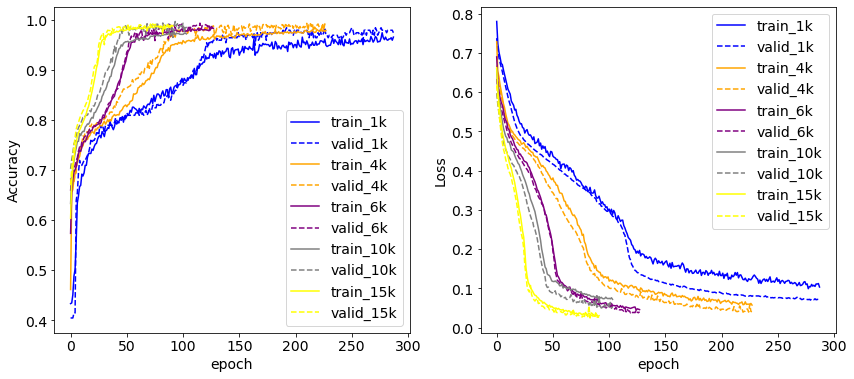

In [95]:
plot_fits(fits2,names,cols)
#Good accuracy but slower convergnece compared to default

In [96]:
#randomuniform
model = compile_model(L_dim,2,'relu',0.2,'adam','random_uniform')
model.save_weights('initial_weights_2.h5')

fits3 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_2.h5')

800
[[-40.14780047  23.74367925]
 [ -3.99705096  -5.63566332]
 [ 40.08857078  39.31850556]
 [-27.05734912  28.33977616]
 [ 32.67662711 -34.60669466]
 [-38.09501723 -16.7916779 ]
 [ -1.52181381 -33.64556534]
 [ -0.93614654  -7.61963386]
 [-33.38763348 -43.55526275]
 [ 29.75292791  -3.74125944]]
Epoch 1/400
16/16 - 0s - loss: 0.6929 - accuracy: 0.5525 - val_loss: 0.6918 - val_accuracy: 0.5750 - 473ms/epoch - 30ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6911 - accuracy: 0.5725 - val_loss: 0.6889 - val_accuracy: 0.5500 - 44ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6880 - accuracy: 0.5537 - val_loss: 0.6841 - val_accuracy: 0.5800 - 47ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6828 - accuracy: 0.5675 - val_loss: 0.6758 - val_accuracy: 0.6500 - 49ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6751 - accuracy: 0.6125 - val_loss: 0.6642 - val_accuracy: 0.7100 - 47ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6645 - accuracy: 0.6350 - val_loss: 0.6491 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.4623 - accuracy: 0.7425 - val_loss: 0.4110 - val_accuracy: 0.7700 - 52ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.4531 - accuracy: 0.7437 - val_loss: 0.4079 - val_accuracy: 0.7700 - 51ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.4589 - accuracy: 0.7387 - val_loss: 0.4038 - val_accuracy: 0.7700 - 48ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.4585 - accuracy: 0.7237 - val_loss: 0.4020 - val_accuracy: 0.7700 - 42ms/epoch - 3ms/step
Epoch 69/400
16/16 - 0s - loss: 0.4560 - accuracy: 0.7513 - val_loss: 0.3983 - val_accuracy: 0.7700 - 41ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.4511 - accuracy: 0.7412 - val_loss: 0.3952 - val_accuracy: 0.7700 - 40ms/epoch - 3ms/step
Epoch 71/400
16/16 - 0s - loss: 0.4517 - accuracy: 0.7362 - val_loss: 0.3922 - val_accuracy: 0.7700 - 40ms/epoch - 2ms/step
Epoch 72/400
16/16 - 0s - loss: 0.4461 - accuracy: 0.7500 - val_loss: 0.3912 - val_accuracy: 0.7700 - 38ms/epoch - 2ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.2195 - accuracy: 0.9100 - val_loss: 0.1577 - val_accuracy: 0.9350 - 40ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.2131 - accuracy: 0.9062 - val_loss: 0.1569 - val_accuracy: 0.9450 - 40ms/epoch - 2ms/step
Epoch 133/400
16/16 - 0s - loss: 0.2076 - accuracy: 0.9062 - val_loss: 0.1549 - val_accuracy: 0.9400 - 40ms/epoch - 2ms/step
Epoch 134/400
16/16 - 0s - loss: 0.2170 - accuracy: 0.9062 - val_loss: 0.1549 - val_accuracy: 0.9400 - 41ms/epoch - 3ms/step
Epoch 135/400
16/16 - 0s - loss: 0.2167 - accuracy: 0.9100 - val_loss: 0.1521 - val_accuracy: 0.9450 - 42ms/epoch - 3ms/step
Epoch 136/400
16/16 - 0s - loss: 0.2086 - accuracy: 0.9100 - val_loss: 0.1551 - val_accuracy: 0.9400 - 40ms/epoch - 2ms/step
Epoch 137/400
16/16 - 0s - loss: 0.2034 - accuracy: 0.9225 - val_loss: 0.1534 - val_accuracy: 0.9400 - 40ms/epoch - 2ms/step
Epoch 138/400
16/16 - 0s - loss: 0.2023 - accuracy: 0.9087 - val_loss: 0.1503 - val_accuracy: 0.9450 - 39ms/epoch - 2ms/step


Epoch 26/400
64/64 - 0s - loss: 0.5475 - accuracy: 0.6619 - val_loss: 0.5112 - val_accuracy: 0.6975 - 90ms/epoch - 1ms/step
Epoch 27/400
64/64 - 0s - loss: 0.5332 - accuracy: 0.6678 - val_loss: 0.4989 - val_accuracy: 0.7038 - 89ms/epoch - 1ms/step
Epoch 28/400
64/64 - 0s - loss: 0.5255 - accuracy: 0.6800 - val_loss: 0.4872 - val_accuracy: 0.7113 - 90ms/epoch - 1ms/step
Epoch 29/400
64/64 - 0s - loss: 0.5129 - accuracy: 0.6850 - val_loss: 0.4741 - val_accuracy: 0.7225 - 90ms/epoch - 1ms/step
Epoch 30/400
64/64 - 0s - loss: 0.5005 - accuracy: 0.6978 - val_loss: 0.4619 - val_accuracy: 0.7337 - 89ms/epoch - 1ms/step
Epoch 31/400
64/64 - 0s - loss: 0.4873 - accuracy: 0.7144 - val_loss: 0.4503 - val_accuracy: 0.7387 - 90ms/epoch - 1ms/step
Epoch 32/400
64/64 - 0s - loss: 0.4777 - accuracy: 0.7178 - val_loss: 0.4401 - val_accuracy: 0.7425 - 89ms/epoch - 1ms/step
Epoch 33/400
64/64 - 0s - loss: 0.4667 - accuracy: 0.7300 - val_loss: 0.4301 - val_accuracy: 0.7450 - 90ms/epoch - 1ms/step
Epoch 34

64/64 - 0s - loss: 0.1954 - accuracy: 0.9178 - val_loss: 0.1628 - val_accuracy: 0.9362 - 88ms/epoch - 1ms/step
Epoch 93/400
64/64 - 0s - loss: 0.1959 - accuracy: 0.9156 - val_loss: 0.1638 - val_accuracy: 0.9375 - 88ms/epoch - 1ms/step
Epoch 94/400
64/64 - 0s - loss: 0.1929 - accuracy: 0.9166 - val_loss: 0.1667 - val_accuracy: 0.9400 - 88ms/epoch - 1ms/step
Epoch 95/400
64/64 - 0s - loss: 0.1914 - accuracy: 0.9162 - val_loss: 0.1591 - val_accuracy: 0.9450 - 90ms/epoch - 1ms/step
Epoch 96/400
64/64 - 0s - loss: 0.1897 - accuracy: 0.9212 - val_loss: 0.1583 - val_accuracy: 0.9438 - 88ms/epoch - 1ms/step
Epoch 97/400
64/64 - 0s - loss: 0.1891 - accuracy: 0.9197 - val_loss: 0.1582 - val_accuracy: 0.9400 - 88ms/epoch - 1ms/step
Epoch 98/400
64/64 - 0s - loss: 0.1880 - accuracy: 0.9203 - val_loss: 0.1557 - val_accuracy: 0.9413 - 89ms/epoch - 1ms/step
Epoch 99/400
64/64 - 0s - loss: 0.1846 - accuracy: 0.9241 - val_loss: 0.1534 - val_accuracy: 0.9450 - 88ms/epoch - 1ms/step
Epoch 100/400
64/64 -

Epoch 158/400
64/64 - 0s - loss: 0.1642 - accuracy: 0.9284 - val_loss: 0.1319 - val_accuracy: 0.9475 - 90ms/epoch - 1ms/step
Epoch 159/400
64/64 - 0s - loss: 0.1639 - accuracy: 0.9284 - val_loss: 0.1327 - val_accuracy: 0.9513 - 89ms/epoch - 1ms/step
Epoch 160/400
64/64 - 0s - loss: 0.1608 - accuracy: 0.9284 - val_loss: 0.1327 - val_accuracy: 0.9488 - 91ms/epoch - 1ms/step
Epoch 161/400
64/64 - 0s - loss: 0.1644 - accuracy: 0.9284 - val_loss: 0.1336 - val_accuracy: 0.9475 - 92ms/epoch - 1ms/step
Epoch 162/400
64/64 - 0s - loss: 0.1630 - accuracy: 0.9300 - val_loss: 0.1327 - val_accuracy: 0.9475 - 91ms/epoch - 1ms/step
Epoch 163/400
64/64 - 0s - loss: 0.1629 - accuracy: 0.9297 - val_loss: 0.1325 - val_accuracy: 0.9450 - 90ms/epoch - 1ms/step
Epoch 164/400
64/64 - 0s - loss: 0.1647 - accuracy: 0.9275 - val_loss: 0.1323 - val_accuracy: 0.9500 - 89ms/epoch - 1ms/step
Epoch 165/400
64/64 - 0s - loss: 0.1614 - accuracy: 0.9300 - val_loss: 0.1318 - val_accuracy: 0.9488 - 90ms/epoch - 1ms/step


Epoch 42/400
96/96 - 0s - loss: 0.2553 - accuracy: 0.8946 - val_loss: 0.2489 - val_accuracy: 0.9075 - 123ms/epoch - 1ms/step
Epoch 43/400
96/96 - 0s - loss: 0.2521 - accuracy: 0.8960 - val_loss: 0.2436 - val_accuracy: 0.9092 - 125ms/epoch - 1ms/step
Epoch 44/400
96/96 - 0s - loss: 0.2497 - accuracy: 0.8954 - val_loss: 0.2411 - val_accuracy: 0.9075 - 123ms/epoch - 1ms/step
Epoch 45/400
96/96 - 0s - loss: 0.2505 - accuracy: 0.8948 - val_loss: 0.2396 - val_accuracy: 0.9142 - 122ms/epoch - 1ms/step
Epoch 46/400
96/96 - 0s - loss: 0.2445 - accuracy: 0.8967 - val_loss: 0.2320 - val_accuracy: 0.9100 - 122ms/epoch - 1ms/step
Epoch 47/400
96/96 - 0s - loss: 0.2428 - accuracy: 0.8958 - val_loss: 0.2407 - val_accuracy: 0.9058 - 121ms/epoch - 1ms/step
Epoch 48/400
96/96 - 0s - loss: 0.2394 - accuracy: 0.8990 - val_loss: 0.2363 - val_accuracy: 0.9158 - 122ms/epoch - 1ms/step
Epoch 49/400
96/96 - 0s - loss: 0.2397 - accuracy: 0.8990 - val_loss: 0.2290 - val_accuracy: 0.9158 - 122ms/epoch - 1ms/step


Epoch 108/400
96/96 - 0s - loss: 0.1637 - accuracy: 0.9298 - val_loss: 0.1627 - val_accuracy: 0.9275 - 123ms/epoch - 1ms/step
Epoch 109/400
96/96 - 0s - loss: 0.1611 - accuracy: 0.9294 - val_loss: 0.1565 - val_accuracy: 0.9333 - 123ms/epoch - 1ms/step
Epoch 110/400
96/96 - 0s - loss: 0.1607 - accuracy: 0.9267 - val_loss: 0.1582 - val_accuracy: 0.9283 - 122ms/epoch - 1ms/step
Epoch 111/400
96/96 - 0s - loss: 0.1598 - accuracy: 0.9317 - val_loss: 0.1594 - val_accuracy: 0.9342 - 122ms/epoch - 1ms/step
Epoch 112/400
96/96 - 0s - loss: 0.1587 - accuracy: 0.9306 - val_loss: 0.1549 - val_accuracy: 0.9350 - 123ms/epoch - 1ms/step
Epoch 113/400
96/96 - 0s - loss: 0.1598 - accuracy: 0.9298 - val_loss: 0.1622 - val_accuracy: 0.9275 - 122ms/epoch - 1ms/step
Epoch 114/400
96/96 - 0s - loss: 0.1561 - accuracy: 0.9317 - val_loss: 0.1523 - val_accuracy: 0.9325 - 121ms/epoch - 1ms/step
Epoch 115/400
96/96 - 0s - loss: 0.1578 - accuracy: 0.9329 - val_loss: 0.1531 - val_accuracy: 0.9333 - 120ms/epoch - 1

96/96 - 0s - loss: 0.0843 - accuracy: 0.9654 - val_loss: 0.0914 - val_accuracy: 0.9600 - 123ms/epoch - 1ms/step
Epoch 174/400
96/96 - 0s - loss: 0.0817 - accuracy: 0.9677 - val_loss: 0.0830 - val_accuracy: 0.9633 - 123ms/epoch - 1ms/step
Epoch 175/400
96/96 - 0s - loss: 0.0842 - accuracy: 0.9635 - val_loss: 0.0823 - val_accuracy: 0.9658 - 121ms/epoch - 1ms/step
Epoch 176/400
96/96 - 0s - loss: 0.0806 - accuracy: 0.9679 - val_loss: 0.0775 - val_accuracy: 0.9700 - 122ms/epoch - 1ms/step
Epoch 177/400
96/96 - 0s - loss: 0.0802 - accuracy: 0.9665 - val_loss: 0.0843 - val_accuracy: 0.9625 - 124ms/epoch - 1ms/step
Epoch 178/400
96/96 - 0s - loss: 0.0744 - accuracy: 0.9706 - val_loss: 0.0779 - val_accuracy: 0.9675 - 122ms/epoch - 1ms/step
Epoch 179/400
96/96 - 0s - loss: 0.0754 - accuracy: 0.9698 - val_loss: 0.0823 - val_accuracy: 0.9625 - 122ms/epoch - 1ms/step
Epoch 180/400
96/96 - 0s - loss: 0.0760 - accuracy: 0.9694 - val_loss: 0.0796 - val_accuracy: 0.9683 - 121ms/epoch - 1ms/step
Epoch 

Epoch 43/400
160/160 - 0s - loss: 0.2800 - accuracy: 0.8751 - val_loss: 0.2658 - val_accuracy: 0.8785 - 186ms/epoch - 1ms/step
Epoch 44/400
160/160 - 0s - loss: 0.2754 - accuracy: 0.8750 - val_loss: 0.2611 - val_accuracy: 0.8820 - 183ms/epoch - 1ms/step
Epoch 45/400
160/160 - 0s - loss: 0.2715 - accuracy: 0.8751 - val_loss: 0.2566 - val_accuracy: 0.8835 - 185ms/epoch - 1ms/step
Epoch 46/400
160/160 - 0s - loss: 0.2672 - accuracy: 0.8776 - val_loss: 0.2472 - val_accuracy: 0.8875 - 185ms/epoch - 1ms/step
Epoch 47/400
160/160 - 0s - loss: 0.2551 - accuracy: 0.8876 - val_loss: 0.2402 - val_accuracy: 0.8920 - 185ms/epoch - 1ms/step
Epoch 48/400
160/160 - 0s - loss: 0.2376 - accuracy: 0.8955 - val_loss: 0.2209 - val_accuracy: 0.8950 - 184ms/epoch - 1ms/step
Epoch 49/400
160/160 - 0s - loss: 0.2202 - accuracy: 0.9051 - val_loss: 0.2025 - val_accuracy: 0.9135 - 189ms/epoch - 1ms/step
Epoch 50/400
160/160 - 0s - loss: 0.2042 - accuracy: 0.9179 - val_loss: 0.1964 - val_accuracy: 0.9210 - 185ms/e

Epoch 108/400
160/160 - 0s - loss: 0.1308 - accuracy: 0.9448 - val_loss: 0.1304 - val_accuracy: 0.9455 - 196ms/epoch - 1ms/step
Epoch 109/400
160/160 - 0s - loss: 0.1287 - accuracy: 0.9486 - val_loss: 0.1268 - val_accuracy: 0.9470 - 188ms/epoch - 1ms/step
Epoch 110/400
160/160 - 0s - loss: 0.1286 - accuracy: 0.9466 - val_loss: 0.1236 - val_accuracy: 0.9475 - 191ms/epoch - 1ms/step
Epoch 111/400
160/160 - 0s - loss: 0.1301 - accuracy: 0.9461 - val_loss: 0.1299 - val_accuracy: 0.9455 - 190ms/epoch - 1ms/step
Epoch 112/400
160/160 - 0s - loss: 0.1302 - accuracy: 0.9470 - val_loss: 0.1296 - val_accuracy: 0.9440 - 198ms/epoch - 1ms/step
Epoch 113/400
160/160 - 0s - loss: 0.1287 - accuracy: 0.9467 - val_loss: 0.1427 - val_accuracy: 0.9395 - 196ms/epoch - 1ms/step
Epoch 114/400
160/160 - 0s - loss: 0.1295 - accuracy: 0.9465 - val_loss: 0.1275 - val_accuracy: 0.9465 - 191ms/epoch - 1ms/step
Epoch 115/400
160/160 - 0s - loss: 0.1280 - accuracy: 0.9473 - val_loss: 0.1251 - val_accuracy: 0.9480 -

Epoch 32/400
240/240 - 0s - loss: 0.2735 - accuracy: 0.8674 - val_loss: 0.2660 - val_accuracy: 0.8673 - 267ms/epoch - 1ms/step
Epoch 33/400
240/240 - 0s - loss: 0.2718 - accuracy: 0.8697 - val_loss: 0.2655 - val_accuracy: 0.8720 - 276ms/epoch - 1ms/step
Epoch 34/400
240/240 - 0s - loss: 0.2692 - accuracy: 0.8713 - val_loss: 0.2656 - val_accuracy: 0.8670 - 272ms/epoch - 1ms/step
Epoch 35/400
240/240 - 0s - loss: 0.2703 - accuracy: 0.8691 - val_loss: 0.2673 - val_accuracy: 0.8757 - 305ms/epoch - 1ms/step
Epoch 36/400
240/240 - 0s - loss: 0.2681 - accuracy: 0.8711 - val_loss: 0.2618 - val_accuracy: 0.8690 - 323ms/epoch - 1ms/step
Epoch 37/400
240/240 - 0s - loss: 0.2673 - accuracy: 0.8714 - val_loss: 0.2628 - val_accuracy: 0.8683 - 342ms/epoch - 1ms/step
Epoch 38/400
240/240 - 0s - loss: 0.2676 - accuracy: 0.8718 - val_loss: 0.2589 - val_accuracy: 0.8737 - 305ms/epoch - 1ms/step
Epoch 39/400
240/240 - 0s - loss: 0.2650 - accuracy: 0.8738 - val_loss: 0.2593 - val_accuracy: 0.8737 - 284ms/e

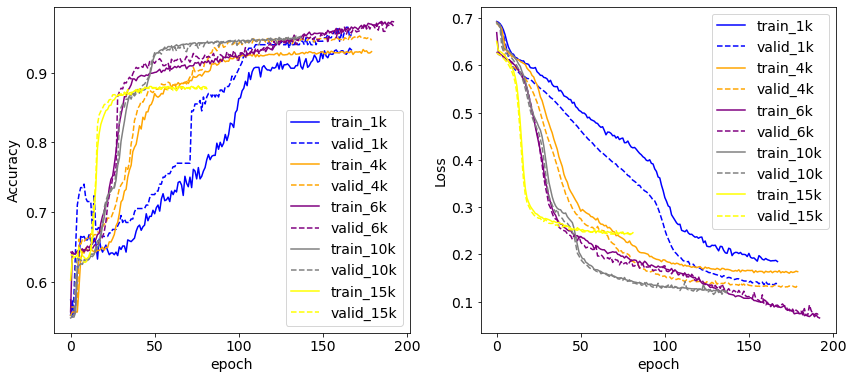

In [98]:
plot_fits(fits3,names,cols)
#Something crazy happened, not good

In [109]:
#randomuniform med intervall

init_al_1 = initializers.RandomUniform(minval=0., maxval=1.)
model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_1)
model.save_weights('initial_weights_3.h5')

fits4 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_3.h5')

800
[[-45.93578547 -41.82574978]
 [ 30.46491116  34.0129399 ]
 [ 33.38712581 -39.44704046]
 [ -2.88468631  40.05486534]
 [ -0.42700401 -33.12250571]
 [ 37.88563309  10.98100022]
 [ 41.1817203   -8.39774696]
 [ 29.26889958 -25.5550321 ]
 [-14.14181078 -32.54358206]
 [-13.46954563  10.63935464]]
Epoch 1/400
16/16 - 0s - loss: 0.7982 - accuracy: 0.6100 - val_loss: 0.5576 - val_accuracy: 0.6950 - 466ms/epoch - 29ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6569 - accuracy: 0.6513 - val_loss: 0.5058 - val_accuracy: 0.7400 - 45ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6276 - accuracy: 0.6775 - val_loss: 0.4895 - val_accuracy: 0.7450 - 44ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.5862 - accuracy: 0.7063 - val_loss: 0.4761 - val_accuracy: 0.7450 - 41ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.5548 - accuracy: 0.7525 - val_loss: 0.4585 - val_accuracy: 0.7650 - 47ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.5444 - accuracy: 0.7513 - val_loss: 0.4396 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.2739 - accuracy: 0.8888 - val_loss: 0.2356 - val_accuracy: 0.9100 - 45ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.2684 - accuracy: 0.8925 - val_loss: 0.2375 - val_accuracy: 0.9050 - 48ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.2733 - accuracy: 0.8900 - val_loss: 0.2354 - val_accuracy: 0.9050 - 45ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.2662 - accuracy: 0.8963 - val_loss: 0.2374 - val_accuracy: 0.9050 - 45ms/epoch - 3ms/step
Epoch 69/400
16/16 - 0s - loss: 0.2752 - accuracy: 0.8913 - val_loss: 0.2340 - val_accuracy: 0.9100 - 45ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.2723 - accuracy: 0.8875 - val_loss: 0.2339 - val_accuracy: 0.9100 - 46ms/epoch - 3ms/step
Epoch 71/400
16/16 - 0s - loss: 0.2697 - accuracy: 0.8963 - val_loss: 0.2355 - val_accuracy: 0.9050 - 45ms/epoch - 3ms/step
Epoch 72/400
16/16 - 0s - loss: 0.2702 - accuracy: 0.8875 - val_loss: 0.2320 - val_accuracy: 0.9100 - 46ms/epoch - 3ms/step
Epoch 73

Epoch 33/400
64/64 - 0s - loss: 0.2136 - accuracy: 0.9200 - val_loss: 0.2001 - val_accuracy: 0.9225 - 98ms/epoch - 2ms/step
Epoch 34/400
64/64 - 0s - loss: 0.2134 - accuracy: 0.9200 - val_loss: 0.1951 - val_accuracy: 0.9312 - 96ms/epoch - 1ms/step
Epoch 35/400
64/64 - 0s - loss: 0.2159 - accuracy: 0.9178 - val_loss: 0.1953 - val_accuracy: 0.9262 - 95ms/epoch - 1ms/step
Epoch 36/400
64/64 - 0s - loss: 0.2129 - accuracy: 0.9219 - val_loss: 0.1976 - val_accuracy: 0.9262 - 101ms/epoch - 2ms/step
Epoch 37/400
64/64 - 0s - loss: 0.2080 - accuracy: 0.9212 - val_loss: 0.1964 - val_accuracy: 0.9200 - 92ms/epoch - 1ms/step
Epoch 38/400
64/64 - 0s - loss: 0.2099 - accuracy: 0.9228 - val_loss: 0.1921 - val_accuracy: 0.9300 - 95ms/epoch - 1ms/step
Epoch 39/400
64/64 - 0s - loss: 0.2093 - accuracy: 0.9216 - val_loss: 0.1949 - val_accuracy: 0.9225 - 92ms/epoch - 1ms/step
Epoch 40/400
64/64 - 0s - loss: 0.2093 - accuracy: 0.9219 - val_loss: 0.1945 - val_accuracy: 0.9212 - 96ms/epoch - 1ms/step
Epoch 4

64/64 - 0s - loss: 0.1716 - accuracy: 0.9291 - val_loss: 0.1508 - val_accuracy: 0.9350 - 94ms/epoch - 1ms/step
Epoch 100/400
64/64 - 0s - loss: 0.1696 - accuracy: 0.9278 - val_loss: 0.1593 - val_accuracy: 0.9312 - 93ms/epoch - 1ms/step
Epoch 101/400
64/64 - 0s - loss: 0.1705 - accuracy: 0.9287 - val_loss: 0.1500 - val_accuracy: 0.9362 - 93ms/epoch - 1ms/step
Epoch 102/400
64/64 - 0s - loss: 0.1687 - accuracy: 0.9275 - val_loss: 0.1502 - val_accuracy: 0.9337 - 92ms/epoch - 1ms/step
Epoch 103/400
64/64 - 0s - loss: 0.1687 - accuracy: 0.9312 - val_loss: 0.1615 - val_accuracy: 0.9262 - 93ms/epoch - 1ms/step
Epoch 104/400
64/64 - 0s - loss: 0.1682 - accuracy: 0.9306 - val_loss: 0.1540 - val_accuracy: 0.9312 - 98ms/epoch - 2ms/step
Epoch 105/400
64/64 - 0s - loss: 0.1679 - accuracy: 0.9297 - val_loss: 0.1543 - val_accuracy: 0.9325 - 110ms/epoch - 2ms/step
Epoch 106/400
64/64 - 0s - loss: 0.1721 - accuracy: 0.9275 - val_loss: 0.1518 - val_accuracy: 0.9350 - 114ms/epoch - 2ms/step
Epoch 107/40

Epoch 40/400
96/96 - 0s - loss: 0.1932 - accuracy: 0.9148 - val_loss: 0.1829 - val_accuracy: 0.9250 - 127ms/epoch - 1ms/step
Epoch 41/400
96/96 - 0s - loss: 0.1925 - accuracy: 0.9154 - val_loss: 0.1871 - val_accuracy: 0.9200 - 133ms/epoch - 1ms/step
Epoch 42/400
96/96 - 0s - loss: 0.1892 - accuracy: 0.9175 - val_loss: 0.1823 - val_accuracy: 0.9242 - 128ms/epoch - 1ms/step
Epoch 43/400
96/96 - 0s - loss: 0.1879 - accuracy: 0.9144 - val_loss: 0.1811 - val_accuracy: 0.9267 - 128ms/epoch - 1ms/step
Epoch 44/400
96/96 - 0s - loss: 0.1868 - accuracy: 0.9175 - val_loss: 0.1825 - val_accuracy: 0.9242 - 128ms/epoch - 1ms/step
Epoch 45/400
96/96 - 0s - loss: 0.1856 - accuracy: 0.9177 - val_loss: 0.1804 - val_accuracy: 0.9283 - 129ms/epoch - 1ms/step
Epoch 46/400
96/96 - 0s - loss: 0.1857 - accuracy: 0.9167 - val_loss: 0.1811 - val_accuracy: 0.9242 - 128ms/epoch - 1ms/step
Epoch 47/400
96/96 - 0s - loss: 0.1839 - accuracy: 0.9185 - val_loss: 0.1810 - val_accuracy: 0.9242 - 126ms/epoch - 1ms/step


Epoch 30/400
160/160 - 0s - loss: 0.1815 - accuracy: 0.9216 - val_loss: 0.1888 - val_accuracy: 0.9220 - 192ms/epoch - 1ms/step
Epoch 31/400
160/160 - 0s - loss: 0.1819 - accuracy: 0.9197 - val_loss: 0.1795 - val_accuracy: 0.9275 - 192ms/epoch - 1ms/step
Epoch 32/400
160/160 - 0s - loss: 0.1834 - accuracy: 0.9195 - val_loss: 0.1787 - val_accuracy: 0.9265 - 190ms/epoch - 1ms/step
Epoch 33/400
160/160 - 0s - loss: 0.1814 - accuracy: 0.9212 - val_loss: 0.1785 - val_accuracy: 0.9280 - 192ms/epoch - 1ms/step
Epoch 34/400
160/160 - 0s - loss: 0.1795 - accuracy: 0.9218 - val_loss: 0.1791 - val_accuracy: 0.9235 - 192ms/epoch - 1ms/step
Epoch 35/400
160/160 - 0s - loss: 0.1762 - accuracy: 0.9233 - val_loss: 0.1773 - val_accuracy: 0.9235 - 190ms/epoch - 1ms/step
Epoch 36/400
160/160 - 0s - loss: 0.1768 - accuracy: 0.9222 - val_loss: 0.1768 - val_accuracy: 0.9240 - 195ms/epoch - 1ms/step
Epoch 37/400
160/160 - 0s - loss: 0.1746 - accuracy: 0.9234 - val_loss: 0.1788 - val_accuracy: 0.9245 - 189ms/e

Epoch 3/400
240/240 - 0s - loss: 0.3106 - accuracy: 0.8726 - val_loss: 0.2971 - val_accuracy: 0.8743 - 273ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2790 - accuracy: 0.8903 - val_loss: 0.2780 - val_accuracy: 0.8883 - 300ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2584 - accuracy: 0.9017 - val_loss: 0.2649 - val_accuracy: 0.8990 - 270ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2478 - accuracy: 0.9043 - val_loss: 0.2575 - val_accuracy: 0.9007 - 294ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2413 - accuracy: 0.9065 - val_loss: 0.2529 - val_accuracy: 0.9007 - 272ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2378 - accuracy: 0.9072 - val_loss: 0.2494 - val_accuracy: 0.9010 - 298ms/epoch - 1ms/step
Epoch 9/400
240/240 - 0s - loss: 0.2326 - accuracy: 0.9074 - val_loss: 0.2458 - val_accuracy: 0.9013 - 279ms/epoch - 1ms/step
Epoch 10/400
240/240 - 0s - loss: 0.2282 - accuracy: 0.9112 - val_loss: 0.2395 - val_accuracy: 0.9027 - 284ms/epoch - 

Epoch 68/400
240/240 - 0s - loss: 0.1692 - accuracy: 0.9245 - val_loss: 0.1867 - val_accuracy: 0.9117 - 336ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.1686 - accuracy: 0.9249 - val_loss: 0.1842 - val_accuracy: 0.9133 - 360ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.1667 - accuracy: 0.9255 - val_loss: 0.1851 - val_accuracy: 0.9143 - 392ms/epoch - 2ms/step


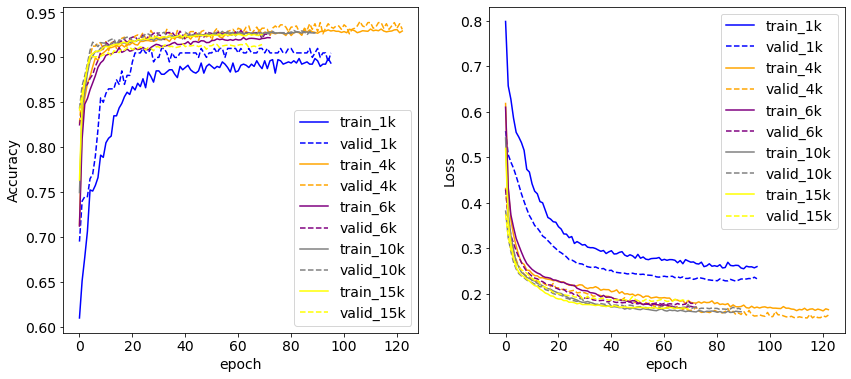

In [110]:
plot_fits(fits4,names,cols)
#Much faster convergence for all sample sizes, but less accuracy
#Should do an average over several runs

In [30]:
x_test,y_test = generate_data(4000)
x_train = x_test[0:N_train]
y_train = y_test[0:N_train]
x_valid = x_test[N_train:]
y_valid = y_test[N_train:]
x_train, x_valid = Rescale(x_train),Rescale(x_valid)

fits_uniform = []

In [111]:
for i in range(5):
    init_al_1 = initializers.RandomUniform(minval=0., maxval=1.)
    model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_1)
    fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
    fits_uniform.append(fit)

Epoch 1/400
240/240 - 1s - loss: 0.8837 - accuracy: 0.6285 - val_loss: 0.5874 - val_accuracy: 0.7417 - 890ms/epoch - 4ms/step
Epoch 2/400
240/240 - 0s - loss: 0.5791 - accuracy: 0.7465 - val_loss: 0.5008 - val_accuracy: 0.7827 - 281ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.4657 - accuracy: 0.8173 - val_loss: 0.4037 - val_accuracy: 0.8483 - 273ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.3713 - accuracy: 0.8698 - val_loss: 0.3245 - val_accuracy: 0.8913 - 272ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.3039 - accuracy: 0.9028 - val_loss: 0.2759 - val_accuracy: 0.9063 - 280ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2679 - accuracy: 0.9161 - val_loss: 0.2537 - val_accuracy: 0.9187 - 281ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2511 - accuracy: 0.9194 - val_loss: 0.2417 - val_accuracy: 0.9227 - 280ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2417 - accuracy: 0.9203 - val_loss: 0.2355 - val_accuracy: 0.9233 - 280ms/epoch - 1

Epoch 66/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9262 - val_loss: 0.2085 - val_accuracy: 0.9283 - 298ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.2094 - accuracy: 0.9280 - val_loss: 0.2085 - val_accuracy: 0.9273 - 301ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.2097 - accuracy: 0.9279 - val_loss: 0.2109 - val_accuracy: 0.9270 - 316ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.2103 - accuracy: 0.9273 - val_loss: 0.2076 - val_accuracy: 0.9290 - 270ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.2094 - accuracy: 0.9277 - val_loss: 0.2109 - val_accuracy: 0.9273 - 313ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.2098 - accuracy: 0.9277 - val_loss: 0.2102 - val_accuracy: 0.9283 - 275ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.2103 - accuracy: 0.9278 - val_loss: 0.2105 - val_accuracy: 0.9260 - 285ms/epoch - 1ms/step
Epoch 73/400
240/240 - 0s - loss: 0.2104 - accuracy: 0.9273 - val_loss: 0.2098 - val_accuracy: 0.9267 - 272ms/e

Epoch 54/400
240/240 - 0s - loss: 0.4070 - accuracy: 0.7588 - val_loss: 0.4008 - val_accuracy: 0.7660 - 269ms/epoch - 1ms/step
Epoch 55/400
240/240 - 0s - loss: 0.4031 - accuracy: 0.7610 - val_loss: 0.3930 - val_accuracy: 0.7707 - 266ms/epoch - 1ms/step
Epoch 56/400
240/240 - 0s - loss: 0.4028 - accuracy: 0.7589 - val_loss: 0.3961 - val_accuracy: 0.7630 - 267ms/epoch - 1ms/step
Epoch 57/400
240/240 - 0s - loss: 0.4017 - accuracy: 0.7615 - val_loss: 0.3916 - val_accuracy: 0.7727 - 266ms/epoch - 1ms/step
Epoch 58/400
240/240 - 0s - loss: 0.3987 - accuracy: 0.7622 - val_loss: 0.3882 - val_accuracy: 0.7723 - 275ms/epoch - 1ms/step
Epoch 59/400
240/240 - 0s - loss: 0.3966 - accuracy: 0.7615 - val_loss: 0.3865 - val_accuracy: 0.7713 - 265ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.3961 - accuracy: 0.7629 - val_loss: 0.3882 - val_accuracy: 0.7737 - 269ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.3950 - accuracy: 0.7638 - val_loss: 0.3961 - val_accuracy: 0.7740 - 266ms/e

Epoch 119/400
240/240 - 0s - loss: 0.1284 - accuracy: 0.9463 - val_loss: 0.1069 - val_accuracy: 0.9567 - 273ms/epoch - 1ms/step
Epoch 120/400
240/240 - 0s - loss: 0.1225 - accuracy: 0.9503 - val_loss: 0.1126 - val_accuracy: 0.9540 - 265ms/epoch - 1ms/step
Epoch 121/400
240/240 - 0s - loss: 0.1208 - accuracy: 0.9520 - val_loss: 0.0955 - val_accuracy: 0.9633 - 264ms/epoch - 1ms/step
Epoch 122/400
240/240 - 0s - loss: 0.1255 - accuracy: 0.9507 - val_loss: 0.1186 - val_accuracy: 0.9543 - 272ms/epoch - 1ms/step
Epoch 123/400
240/240 - 0s - loss: 0.1159 - accuracy: 0.9553 - val_loss: 0.1000 - val_accuracy: 0.9590 - 270ms/epoch - 1ms/step
Epoch 124/400
240/240 - 0s - loss: 0.1135 - accuracy: 0.9557 - val_loss: 0.0910 - val_accuracy: 0.9633 - 263ms/epoch - 1ms/step
Epoch 125/400
240/240 - 0s - loss: 0.1099 - accuracy: 0.9592 - val_loss: 0.0971 - val_accuracy: 0.9633 - 277ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.1054 - accuracy: 0.9593 - val_loss: 0.0875 - val_accuracy: 0.9707 -

Epoch 14/400
240/240 - 0s - loss: 0.2129 - accuracy: 0.9180 - val_loss: 0.2090 - val_accuracy: 0.9173 - 293ms/epoch - 1ms/step
Epoch 15/400
240/240 - 0s - loss: 0.2102 - accuracy: 0.9174 - val_loss: 0.2084 - val_accuracy: 0.9173 - 324ms/epoch - 1ms/step
Epoch 16/400
240/240 - 0s - loss: 0.2077 - accuracy: 0.9198 - val_loss: 0.2032 - val_accuracy: 0.9190 - 292ms/epoch - 1ms/step
Epoch 17/400
240/240 - 0s - loss: 0.2059 - accuracy: 0.9202 - val_loss: 0.1981 - val_accuracy: 0.9233 - 319ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.2026 - accuracy: 0.9204 - val_loss: 0.1985 - val_accuracy: 0.9220 - 274ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.2028 - accuracy: 0.9185 - val_loss: 0.1938 - val_accuracy: 0.9240 - 298ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.1989 - accuracy: 0.9204 - val_loss: 0.1926 - val_accuracy: 0.9243 - 275ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.1987 - accuracy: 0.9202 - val_loss: 0.1906 - val_accuracy: 0.9230 - 307ms/e

Epoch 79/400
240/240 - 0s - loss: 0.1655 - accuracy: 0.9264 - val_loss: 0.1601 - val_accuracy: 0.9267 - 294ms/epoch - 1ms/step
Epoch 80/400
240/240 - 0s - loss: 0.1651 - accuracy: 0.9261 - val_loss: 0.1640 - val_accuracy: 0.9250 - 280ms/epoch - 1ms/step
Epoch 81/400
240/240 - 0s - loss: 0.1651 - accuracy: 0.9256 - val_loss: 0.1714 - val_accuracy: 0.9227 - 334ms/epoch - 1ms/step
Epoch 82/400
240/240 - 0s - loss: 0.1649 - accuracy: 0.9263 - val_loss: 0.1602 - val_accuracy: 0.9280 - 312ms/epoch - 1ms/step
Epoch 83/400
240/240 - 0s - loss: 0.1650 - accuracy: 0.9270 - val_loss: 0.1613 - val_accuracy: 0.9243 - 294ms/epoch - 1ms/step
Epoch 84/400
240/240 - 0s - loss: 0.1649 - accuracy: 0.9269 - val_loss: 0.1597 - val_accuracy: 0.9273 - 266ms/epoch - 1ms/step
Epoch 85/400
240/240 - 0s - loss: 0.1641 - accuracy: 0.9267 - val_loss: 0.1596 - val_accuracy: 0.9263 - 266ms/epoch - 1ms/step
Epoch 1/400
240/240 - 1s - loss: 0.6833 - accuracy: 0.6076 - val_loss: 0.5897 - val_accuracy: 0.6800 - 677ms/ep

Epoch 15/400
240/240 - 0s - loss: 0.2625 - accuracy: 0.8921 - val_loss: 0.2292 - val_accuracy: 0.9040 - 278ms/epoch - 1ms/step
Epoch 16/400
240/240 - 0s - loss: 0.2564 - accuracy: 0.8935 - val_loss: 0.2285 - val_accuracy: 0.9040 - 320ms/epoch - 1ms/step
Epoch 17/400
240/240 - 0s - loss: 0.2508 - accuracy: 0.8964 - val_loss: 0.2197 - val_accuracy: 0.9013 - 291ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.2482 - accuracy: 0.8952 - val_loss: 0.2175 - val_accuracy: 0.9037 - 276ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.2440 - accuracy: 0.8988 - val_loss: 0.2174 - val_accuracy: 0.9063 - 296ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.2385 - accuracy: 0.9000 - val_loss: 0.2083 - val_accuracy: 0.9087 - 318ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.2389 - accuracy: 0.9000 - val_loss: 0.2072 - val_accuracy: 0.9103 - 288ms/epoch - 1ms/step
Epoch 22/400
240/240 - 0s - loss: 0.2305 - accuracy: 0.9022 - val_loss: 0.2008 - val_accuracy: 0.9117 - 289ms/e

Epoch 80/400
240/240 - 0s - loss: 0.1272 - accuracy: 0.9473 - val_loss: 0.0927 - val_accuracy: 0.9647 - 320ms/epoch - 1ms/step
Epoch 81/400
240/240 - 0s - loss: 0.1238 - accuracy: 0.9500 - val_loss: 0.0920 - val_accuracy: 0.9640 - 291ms/epoch - 1ms/step
Epoch 82/400
240/240 - 0s - loss: 0.1211 - accuracy: 0.9528 - val_loss: 0.0914 - val_accuracy: 0.9643 - 300ms/epoch - 1ms/step
Epoch 83/400
240/240 - 0s - loss: 0.1219 - accuracy: 0.9494 - val_loss: 0.0892 - val_accuracy: 0.9657 - 276ms/epoch - 1ms/step
Epoch 84/400
240/240 - 0s - loss: 0.1189 - accuracy: 0.9533 - val_loss: 0.0955 - val_accuracy: 0.9630 - 292ms/epoch - 1ms/step
Epoch 85/400
240/240 - 0s - loss: 0.1174 - accuracy: 0.9544 - val_loss: 0.0856 - val_accuracy: 0.9707 - 290ms/epoch - 1ms/step
Epoch 86/400
240/240 - 0s - loss: 0.1120 - accuracy: 0.9563 - val_loss: 0.0852 - val_accuracy: 0.9710 - 294ms/epoch - 1ms/step
Epoch 87/400
240/240 - 0s - loss: 0.1136 - accuracy: 0.9538 - val_loss: 0.0796 - val_accuracy: 0.9717 - 276ms/e

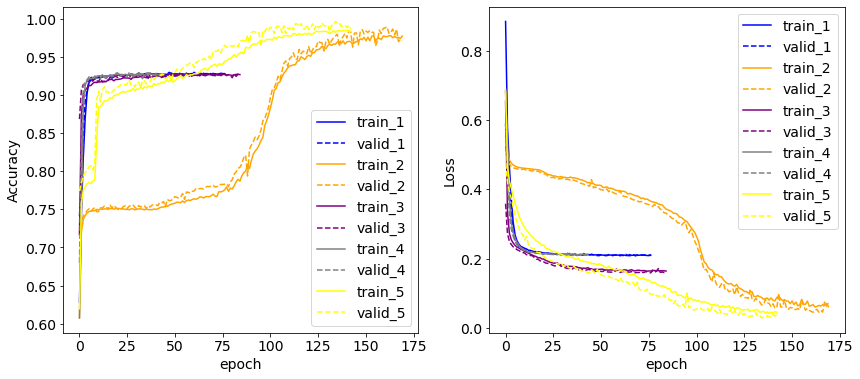

In [112]:
runs = ['1','2','3','4','5']
plot_fits(fits_uniform,runs,cols)

#### Kommentar
When using uniform distribution for initialization, the model seems to truncate around 0.93 in accuracy, while the cases that yields a very good accuracy, actually needs the same amount of epochs as before.

The method of averaging should be used in all cases of the initializer-testing, as the model is quite sensitive to its initial weights. (Ask christoffer about box-plot)

In [101]:
#GlorutUniform (appearantly glorut is the default in keras)
init_al_3 = initializers.GlorotUniform()
model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_3)
model.save_weights('initial_weights_5.h5')

fits4 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_5.h5')

800
[[-38.55585759  46.44917954]
 [-47.77168807 -49.80179012]
 [ 27.44090163 -42.25309181]
 [  7.39983783  -8.07804626]
 [-34.27174057 -20.52609255]
 [  7.11855981  18.33761484]
 [-42.3108041   21.8433038 ]
 [ 47.3557604   -1.66601686]
 [-40.57132357 -37.8606284 ]
 [ 29.95370309  31.39143666]]
Epoch 1/400
16/16 - 0s - loss: 0.6973 - accuracy: 0.4787 - val_loss: 0.6947 - val_accuracy: 0.4200 - 469ms/epoch - 29ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6889 - accuracy: 0.5550 - val_loss: 0.6892 - val_accuracy: 0.5350 - 40ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6821 - accuracy: 0.5788 - val_loss: 0.6848 - val_accuracy: 0.5350 - 41ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6748 - accuracy: 0.5863 - val_loss: 0.6791 - val_accuracy: 0.5350 - 49ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6667 - accuracy: 0.5863 - val_loss: 0.6694 - val_accuracy: 0.5350 - 42ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6554 - accuracy: 0.5863 - val_loss: 0.6582 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.2411 - accuracy: 0.9175 - val_loss: 0.2423 - val_accuracy: 0.9250 - 51ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.2347 - accuracy: 0.9100 - val_loss: 0.2375 - val_accuracy: 0.9250 - 46ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.2331 - accuracy: 0.9250 - val_loss: 0.2333 - val_accuracy: 0.9300 - 43ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.2391 - accuracy: 0.9112 - val_loss: 0.2336 - val_accuracy: 0.9300 - 38ms/epoch - 2ms/step
Epoch 69/400
16/16 - 0s - loss: 0.2270 - accuracy: 0.9100 - val_loss: 0.2316 - val_accuracy: 0.9250 - 43ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.2436 - accuracy: 0.9062 - val_loss: 0.2291 - val_accuracy: 0.9300 - 40ms/epoch - 2ms/step
Epoch 71/400
16/16 - 0s - loss: 0.2245 - accuracy: 0.9237 - val_loss: 0.2286 - val_accuracy: 0.9300 - 43ms/epoch - 3ms/step
Epoch 72/400
16/16 - 0s - loss: 0.2336 - accuracy: 0.9237 - val_loss: 0.2249 - val_accuracy: 0.9400 - 49ms/epoch - 3ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.1716 - accuracy: 0.9413 - val_loss: 0.1725 - val_accuracy: 0.9300 - 44ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.1745 - accuracy: 0.9362 - val_loss: 0.1707 - val_accuracy: 0.9250 - 46ms/epoch - 3ms/step
Epoch 133/400
16/16 - 0s - loss: 0.1764 - accuracy: 0.9375 - val_loss: 0.1703 - val_accuracy: 0.9250 - 50ms/epoch - 3ms/step
Epoch 134/400
16/16 - 0s - loss: 0.1806 - accuracy: 0.9250 - val_loss: 0.1835 - val_accuracy: 0.9300 - 49ms/epoch - 3ms/step
Epoch 135/400
16/16 - 0s - loss: 0.1737 - accuracy: 0.9400 - val_loss: 0.1701 - val_accuracy: 0.9250 - 51ms/epoch - 3ms/step
Epoch 136/400
16/16 - 0s - loss: 0.1750 - accuracy: 0.9400 - val_loss: 0.1678 - val_accuracy: 0.9200 - 46ms/epoch - 3ms/step
Epoch 137/400
16/16 - 0s - loss: 0.1748 - accuracy: 0.9375 - val_loss: 0.1716 - val_accuracy: 0.9250 - 40ms/epoch - 3ms/step
Epoch 138/400
16/16 - 0s - loss: 0.1694 - accuracy: 0.9350 - val_loss: 0.1685 - val_accuracy: 0.9250 - 38ms/epoch - 2ms/step


Epoch 32/400
64/64 - 0s - loss: 0.2753 - accuracy: 0.8847 - val_loss: 0.2805 - val_accuracy: 0.8637 - 100ms/epoch - 2ms/step
Epoch 33/400
64/64 - 0s - loss: 0.2725 - accuracy: 0.8778 - val_loss: 0.2712 - val_accuracy: 0.8725 - 120ms/epoch - 2ms/step
Epoch 34/400
64/64 - 0s - loss: 0.2677 - accuracy: 0.8813 - val_loss: 0.2649 - val_accuracy: 0.8750 - 100ms/epoch - 2ms/step
Epoch 35/400
64/64 - 0s - loss: 0.2627 - accuracy: 0.8878 - val_loss: 0.2622 - val_accuracy: 0.8850 - 97ms/epoch - 2ms/step
Epoch 36/400
64/64 - 0s - loss: 0.2554 - accuracy: 0.8919 - val_loss: 0.2597 - val_accuracy: 0.8800 - 121ms/epoch - 2ms/step
Epoch 37/400
64/64 - 0s - loss: 0.2563 - accuracy: 0.8916 - val_loss: 0.2580 - val_accuracy: 0.8838 - 110ms/epoch - 2ms/step
Epoch 38/400
64/64 - 0s - loss: 0.2466 - accuracy: 0.8944 - val_loss: 0.2443 - val_accuracy: 0.8938 - 91ms/epoch - 1ms/step
Epoch 39/400
64/64 - 0s - loss: 0.2404 - accuracy: 0.9025 - val_loss: 0.2401 - val_accuracy: 0.9013 - 111ms/epoch - 2ms/step
Ep

Epoch 98/400
64/64 - 0s - loss: 0.1673 - accuracy: 0.9319 - val_loss: 0.1624 - val_accuracy: 0.9325 - 97ms/epoch - 2ms/step
Epoch 99/400
64/64 - 0s - loss: 0.1702 - accuracy: 0.9328 - val_loss: 0.1588 - val_accuracy: 0.9337 - 93ms/epoch - 1ms/step
Epoch 100/400
64/64 - 0s - loss: 0.1672 - accuracy: 0.9337 - val_loss: 0.1597 - val_accuracy: 0.9337 - 91ms/epoch - 1ms/step
Epoch 101/400
64/64 - 0s - loss: 0.1648 - accuracy: 0.9350 - val_loss: 0.1611 - val_accuracy: 0.9337 - 92ms/epoch - 1ms/step
Epoch 102/400
64/64 - 0s - loss: 0.1668 - accuracy: 0.9328 - val_loss: 0.1642 - val_accuracy: 0.9262 - 95ms/epoch - 1ms/step
Epoch 103/400
64/64 - 0s - loss: 0.1674 - accuracy: 0.9331 - val_loss: 0.1578 - val_accuracy: 0.9300 - 90ms/epoch - 1ms/step
Epoch 104/400
64/64 - 0s - loss: 0.1657 - accuracy: 0.9341 - val_loss: 0.1607 - val_accuracy: 0.9375 - 93ms/epoch - 1ms/step
Epoch 105/400
64/64 - 0s - loss: 0.1666 - accuracy: 0.9347 - val_loss: 0.1574 - val_accuracy: 0.9300 - 92ms/epoch - 1ms/step
Ep

Epoch 43/400
96/96 - 0s - loss: 0.1452 - accuracy: 0.9431 - val_loss: 0.1539 - val_accuracy: 0.9408 - 124ms/epoch - 1ms/step
Epoch 44/400
96/96 - 0s - loss: 0.1441 - accuracy: 0.9431 - val_loss: 0.1544 - val_accuracy: 0.9400 - 123ms/epoch - 1ms/step
Epoch 45/400
96/96 - 0s - loss: 0.1450 - accuracy: 0.9440 - val_loss: 0.1505 - val_accuracy: 0.9433 - 130ms/epoch - 1ms/step
Epoch 46/400
96/96 - 0s - loss: 0.1412 - accuracy: 0.9442 - val_loss: 0.1471 - val_accuracy: 0.9500 - 126ms/epoch - 1ms/step
Epoch 47/400
96/96 - 0s - loss: 0.1389 - accuracy: 0.9463 - val_loss: 0.1502 - val_accuracy: 0.9367 - 126ms/epoch - 1ms/step
Epoch 48/400
96/96 - 0s - loss: 0.1391 - accuracy: 0.9433 - val_loss: 0.1437 - val_accuracy: 0.9475 - 125ms/epoch - 1ms/step
Epoch 49/400
96/96 - 0s - loss: 0.1350 - accuracy: 0.9446 - val_loss: 0.1438 - val_accuracy: 0.9483 - 131ms/epoch - 1ms/step
Epoch 50/400
96/96 - 0s - loss: 0.1332 - accuracy: 0.9442 - val_loss: 0.1435 - val_accuracy: 0.9442 - 126ms/epoch - 1ms/step


Epoch 109/400
96/96 - 0s - loss: 0.0511 - accuracy: 0.9840 - val_loss: 0.0544 - val_accuracy: 0.9800 - 126ms/epoch - 1ms/step
Epoch 110/400
96/96 - 0s - loss: 0.0507 - accuracy: 0.9837 - val_loss: 0.0522 - val_accuracy: 0.9800 - 132ms/epoch - 1ms/step
Epoch 111/400
96/96 - 0s - loss: 0.0526 - accuracy: 0.9827 - val_loss: 0.0573 - val_accuracy: 0.9775 - 122ms/epoch - 1ms/step
Epoch 112/400
96/96 - 0s - loss: 0.0532 - accuracy: 0.9796 - val_loss: 0.0566 - val_accuracy: 0.9767 - 122ms/epoch - 1ms/step
Epoch 113/400
96/96 - 0s - loss: 0.0485 - accuracy: 0.9837 - val_loss: 0.0484 - val_accuracy: 0.9875 - 123ms/epoch - 1ms/step
Epoch 114/400
96/96 - 0s - loss: 0.0544 - accuracy: 0.9798 - val_loss: 0.0654 - val_accuracy: 0.9725 - 122ms/epoch - 1ms/step
Epoch 115/400
96/96 - 0s - loss: 0.0496 - accuracy: 0.9856 - val_loss: 0.0489 - val_accuracy: 0.9817 - 123ms/epoch - 1ms/step
Epoch 116/400
96/96 - 0s - loss: 0.0470 - accuracy: 0.9848 - val_loss: 0.0577 - val_accuracy: 0.9708 - 122ms/epoch - 1

Epoch 31/400
160/160 - 0s - loss: 0.1532 - accuracy: 0.9452 - val_loss: 0.1445 - val_accuracy: 0.9535 - 214ms/epoch - 1ms/step
Epoch 32/400
160/160 - 0s - loss: 0.1504 - accuracy: 0.9448 - val_loss: 0.1371 - val_accuracy: 0.9555 - 194ms/epoch - 1ms/step
Epoch 33/400
160/160 - 0s - loss: 0.1453 - accuracy: 0.9486 - val_loss: 0.1349 - val_accuracy: 0.9595 - 190ms/epoch - 1ms/step
Epoch 34/400
160/160 - 0s - loss: 0.1412 - accuracy: 0.9494 - val_loss: 0.1331 - val_accuracy: 0.9555 - 201ms/epoch - 1ms/step
Epoch 35/400
160/160 - 0s - loss: 0.1392 - accuracy: 0.9506 - val_loss: 0.1310 - val_accuracy: 0.9600 - 201ms/epoch - 1ms/step
Epoch 36/400
160/160 - 0s - loss: 0.1327 - accuracy: 0.9531 - val_loss: 0.1238 - val_accuracy: 0.9595 - 192ms/epoch - 1ms/step
Epoch 37/400
160/160 - 0s - loss: 0.1316 - accuracy: 0.9524 - val_loss: 0.1212 - val_accuracy: 0.9650 - 193ms/epoch - 1ms/step
Epoch 38/400
160/160 - 0s - loss: 0.1315 - accuracy: 0.9504 - val_loss: 0.1178 - val_accuracy: 0.9575 - 198ms/e

Epoch 96/400
160/160 - 0s - loss: 0.0476 - accuracy: 0.9830 - val_loss: 0.0422 - val_accuracy: 0.9820 - 193ms/epoch - 1ms/step
Epoch 97/400
160/160 - 0s - loss: 0.0496 - accuracy: 0.9808 - val_loss: 0.0431 - val_accuracy: 0.9830 - 199ms/epoch - 1ms/step
Epoch 98/400
160/160 - 0s - loss: 0.0507 - accuracy: 0.9809 - val_loss: 0.0391 - val_accuracy: 0.9865 - 189ms/epoch - 1ms/step
Epoch 99/400
160/160 - 0s - loss: 0.0460 - accuracy: 0.9851 - val_loss: 0.0442 - val_accuracy: 0.9825 - 252ms/epoch - 2ms/step
Epoch 100/400
160/160 - 0s - loss: 0.0454 - accuracy: 0.9849 - val_loss: 0.0420 - val_accuracy: 0.9860 - 210ms/epoch - 1ms/step
12000
[[-46.55145285  20.28545327]
 [-35.82199205 -39.34739224]
 [ -3.99906004 -28.35494749]
 [ 15.07366718  14.94305414]
 [ -5.03390815   5.9775984 ]
 [ 46.38931679 -20.69213187]
 [ 19.14122642  34.4795918 ]
 [ -0.61053752  19.10860062]
 [ 20.06456914  -1.39673956]
 [ 46.32031155 -17.82276579]]
Epoch 1/400
240/240 - 0s - loss: 0.6648 - accuracy: 0.5472 - val_lo

Epoch 59/400
240/240 - 0s - loss: 0.0495 - accuracy: 0.9829 - val_loss: 0.0347 - val_accuracy: 0.9913 - 274ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.0465 - accuracy: 0.9845 - val_loss: 0.0451 - val_accuracy: 0.9820 - 277ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.0493 - accuracy: 0.9819 - val_loss: 0.0323 - val_accuracy: 0.9930 - 283ms/epoch - 1ms/step
Epoch 62/400
240/240 - 0s - loss: 0.0443 - accuracy: 0.9836 - val_loss: 0.0366 - val_accuracy: 0.9850 - 280ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0437 - accuracy: 0.9846 - val_loss: 0.0329 - val_accuracy: 0.9890 - 278ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.0429 - accuracy: 0.9839 - val_loss: 0.0299 - val_accuracy: 0.9927 - 271ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.0409 - accuracy: 0.9847 - val_loss: 0.0268 - val_accuracy: 0.9977 - 265ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.0409 - accuracy: 0.9858 - val_loss: 0.0269 - val_accuracy: 0.9933 - 287ms/e

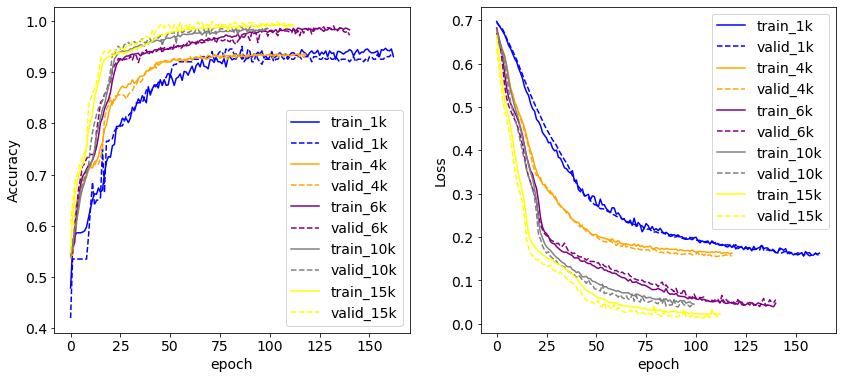

In [103]:
plot_fits(fits4,names,cols)

In [114]:
fits_glorut_uniform = []

for i in range(5):
    init_al_s = initializers.GlorotUniform()
    model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_s)
    fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
    fits_glorut_uniform.append(fit)

Epoch 1/400
240/240 - 1s - loss: 0.6489 - accuracy: 0.6225 - val_loss: 0.6113 - val_accuracy: 0.6930 - 699ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.5037 - accuracy: 0.7800 - val_loss: 0.3675 - val_accuracy: 0.8847 - 277ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3265 - accuracy: 0.8842 - val_loss: 0.2825 - val_accuracy: 0.9170 - 271ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2726 - accuracy: 0.9072 - val_loss: 0.2481 - val_accuracy: 0.9210 - 269ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2468 - accuracy: 0.9133 - val_loss: 0.2348 - val_accuracy: 0.9117 - 272ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2318 - accuracy: 0.9147 - val_loss: 0.2132 - val_accuracy: 0.9193 - 276ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2182 - accuracy: 0.9128 - val_loss: 0.2149 - val_accuracy: 0.9093 - 270ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2082 - accuracy: 0.9138 - val_loss: 0.1939 - val_accuracy: 0.9183 - 273ms/epoch - 1

Epoch 1/400
240/240 - 1s - loss: 0.6243 - accuracy: 0.5982 - val_loss: 0.5338 - val_accuracy: 0.6977 - 734ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4896 - accuracy: 0.7324 - val_loss: 0.4286 - val_accuracy: 0.8187 - 271ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3962 - accuracy: 0.8583 - val_loss: 0.3390 - val_accuracy: 0.8990 - 292ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.3249 - accuracy: 0.8981 - val_loss: 0.2791 - val_accuracy: 0.9117 - 264ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2768 - accuracy: 0.9053 - val_loss: 0.2425 - val_accuracy: 0.9197 - 270ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2468 - accuracy: 0.9105 - val_loss: 0.2174 - val_accuracy: 0.9180 - 258ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2262 - accuracy: 0.9181 - val_loss: 0.2026 - val_accuracy: 0.9297 - 264ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2083 - accuracy: 0.9245 - val_loss: 0.1870 - val_accuracy: 0.9423 - 268ms/epoch - 1

Epoch 66/400
240/240 - 0s - loss: 0.0569 - accuracy: 0.9780 - val_loss: 0.0383 - val_accuracy: 0.9923 - 279ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.0544 - accuracy: 0.9810 - val_loss: 0.0811 - val_accuracy: 0.9730 - 304ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.0408 - val_accuracy: 0.9887 - 312ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.0544 - accuracy: 0.9792 - val_loss: 0.0332 - val_accuracy: 0.9953 - 309ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.0534 - accuracy: 0.9812 - val_loss: 0.0437 - val_accuracy: 0.9873 - 275ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.0532 - accuracy: 0.9811 - val_loss: 0.0352 - val_accuracy: 0.9893 - 301ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.0489 - accuracy: 0.9833 - val_loss: 0.0316 - val_accuracy: 0.9953 - 269ms/epoch - 1ms/step
Epoch 73/400
240/240 - 0s - loss: 0.0504 - accuracy: 0.9822 - val_loss: 0.0308 - val_accuracy: 0.9953 - 280ms/e

Epoch 41/400
240/240 - 0s - loss: 0.1664 - accuracy: 0.9241 - val_loss: 0.1647 - val_accuracy: 0.9217 - 263ms/epoch - 1ms/step
Epoch 42/400
240/240 - 0s - loss: 0.1647 - accuracy: 0.9244 - val_loss: 0.1604 - val_accuracy: 0.9253 - 281ms/epoch - 1ms/step
Epoch 43/400
240/240 - 0s - loss: 0.1619 - accuracy: 0.9252 - val_loss: 0.1608 - val_accuracy: 0.9223 - 262ms/epoch - 1ms/step
Epoch 44/400
240/240 - 0s - loss: 0.1632 - accuracy: 0.9245 - val_loss: 0.1568 - val_accuracy: 0.9277 - 268ms/epoch - 1ms/step
Epoch 45/400
240/240 - 0s - loss: 0.1594 - accuracy: 0.9265 - val_loss: 0.1557 - val_accuracy: 0.9287 - 262ms/epoch - 1ms/step
Epoch 46/400
240/240 - 0s - loss: 0.1605 - accuracy: 0.9255 - val_loss: 0.1569 - val_accuracy: 0.9273 - 264ms/epoch - 1ms/step
Epoch 47/400
240/240 - 0s - loss: 0.1597 - accuracy: 0.9249 - val_loss: 0.1520 - val_accuracy: 0.9283 - 271ms/epoch - 1ms/step
Epoch 48/400
240/240 - 0s - loss: 0.1592 - accuracy: 0.9246 - val_loss: 0.1525 - val_accuracy: 0.9277 - 264ms/e

Epoch 106/400
240/240 - 0s - loss: 0.0740 - accuracy: 0.9718 - val_loss: 0.0651 - val_accuracy: 0.9743 - 298ms/epoch - 1ms/step
Epoch 107/400
240/240 - 0s - loss: 0.0722 - accuracy: 0.9719 - val_loss: 0.0665 - val_accuracy: 0.9803 - 276ms/epoch - 1ms/step
Epoch 108/400
240/240 - 0s - loss: 0.0726 - accuracy: 0.9729 - val_loss: 0.0664 - val_accuracy: 0.9703 - 278ms/epoch - 1ms/step
Epoch 109/400
240/240 - 0s - loss: 0.0755 - accuracy: 0.9707 - val_loss: 0.0519 - val_accuracy: 0.9873 - 279ms/epoch - 1ms/step
Epoch 110/400
240/240 - 0s - loss: 0.0700 - accuracy: 0.9720 - val_loss: 0.0546 - val_accuracy: 0.9847 - 275ms/epoch - 1ms/step
Epoch 111/400
240/240 - 0s - loss: 0.0673 - accuracy: 0.9743 - val_loss: 0.0600 - val_accuracy: 0.9793 - 266ms/epoch - 1ms/step
Epoch 112/400
240/240 - 0s - loss: 0.0645 - accuracy: 0.9758 - val_loss: 0.0497 - val_accuracy: 0.9877 - 265ms/epoch - 1ms/step
Epoch 113/400
240/240 - 0s - loss: 0.0657 - accuracy: 0.9750 - val_loss: 0.0512 - val_accuracy: 0.9850 -

Epoch 15/400
240/240 - 0s - loss: 0.1830 - accuracy: 0.9200 - val_loss: 0.1697 - val_accuracy: 0.9250 - 288ms/epoch - 1ms/step
Epoch 16/400
240/240 - 0s - loss: 0.1789 - accuracy: 0.9214 - val_loss: 0.1703 - val_accuracy: 0.9243 - 368ms/epoch - 2ms/step
Epoch 17/400
240/240 - 0s - loss: 0.1782 - accuracy: 0.9202 - val_loss: 0.1676 - val_accuracy: 0.9243 - 344ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.1770 - accuracy: 0.9212 - val_loss: 0.1683 - val_accuracy: 0.9240 - 322ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.1768 - accuracy: 0.9215 - val_loss: 0.1672 - val_accuracy: 0.9250 - 291ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.1757 - accuracy: 0.9218 - val_loss: 0.1657 - val_accuracy: 0.9263 - 290ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.1741 - accuracy: 0.9216 - val_loss: 0.1643 - val_accuracy: 0.9270 - 286ms/epoch - 1ms/step
Epoch 22/400
240/240 - 0s - loss: 0.1736 - accuracy: 0.9228 - val_loss: 0.1652 - val_accuracy: 0.9237 - 296ms/e

Epoch 16/400
240/240 - 0s - loss: 0.1247 - accuracy: 0.9485 - val_loss: 0.1033 - val_accuracy: 0.9627 - 275ms/epoch - 1ms/step
Epoch 17/400
240/240 - 0s - loss: 0.1166 - accuracy: 0.9588 - val_loss: 0.0954 - val_accuracy: 0.9750 - 284ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.1064 - accuracy: 0.9663 - val_loss: 0.0950 - val_accuracy: 0.9713 - 280ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.0965 - accuracy: 0.9735 - val_loss: 0.0812 - val_accuracy: 0.9757 - 351ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.0932 - accuracy: 0.9741 - val_loss: 0.0830 - val_accuracy: 0.9680 - 299ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.0877 - accuracy: 0.9770 - val_loss: 0.0700 - val_accuracy: 0.9850 - 287ms/epoch - 1ms/step
Epoch 22/400
240/240 - 0s - loss: 0.0844 - accuracy: 0.9784 - val_loss: 0.0675 - val_accuracy: 0.9883 - 295ms/epoch - 1ms/step
Epoch 23/400
240/240 - 0s - loss: 0.0755 - accuracy: 0.9814 - val_loss: 0.0595 - val_accuracy: 0.9927 - 334ms/e

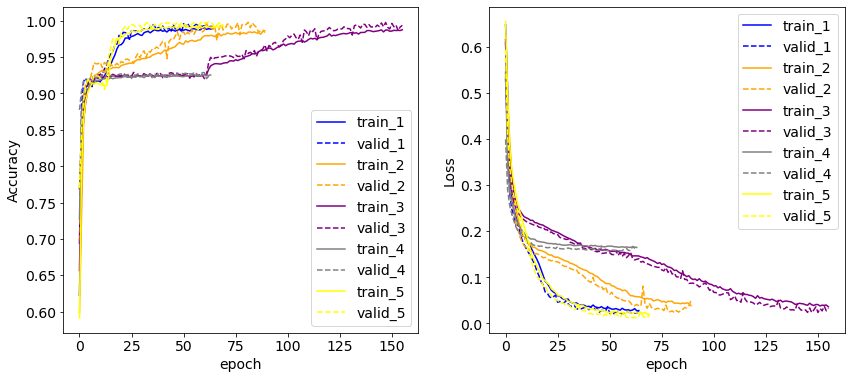

In [115]:
plot_fits(fits_glorut_uniform,runs,cols)

This looks like the best option so far, and is probably the default used in the model as the convergence is comparable to the first run we did.

In [128]:
init_al_g = initializers.GlorotUniform()
fits_avg_glorot = avg_test(4000,10,0.8,2,400,init_al_g)

Epoch 1/400
240/240 - 1s - loss: 0.6382 - accuracy: 0.5980 - val_loss: 0.5567 - val_accuracy: 0.7327 - 700ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4673 - accuracy: 0.7754 - val_loss: 0.3873 - val_accuracy: 0.8420 - 286ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3639 - accuracy: 0.8427 - val_loss: 0.3240 - val_accuracy: 0.8660 - 286ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.3149 - accuracy: 0.8687 - val_loss: 0.2867 - val_accuracy: 0.8827 - 274ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2808 - accuracy: 0.8854 - val_loss: 0.2636 - val_accuracy: 0.8870 - 273ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2576 - accuracy: 0.8936 - val_loss: 0.2418 - val_accuracy: 0.8977 - 273ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2393 - accuracy: 0.8969 - val_loss: 0.2252 - val_accuracy: 0.8977 - 271ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2235 - accuracy: 0.9028 - val_loss: 0.2119 - val_accuracy: 0.9047 - 273ms/epoch - 1

Epoch 66/400
240/240 - 0s - loss: 0.0272 - accuracy: 0.9884 - val_loss: 0.0461 - val_accuracy: 0.9793 - 270ms/epoch - 1ms/step
Epoch 1/400
240/240 - 1s - loss: 0.5842 - accuracy: 0.6309 - val_loss: 0.5119 - val_accuracy: 0.7080 - 790ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4972 - accuracy: 0.7258 - val_loss: 0.4772 - val_accuracy: 0.7320 - 294ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.4785 - accuracy: 0.7390 - val_loss: 0.4669 - val_accuracy: 0.7410 - 261ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.4702 - accuracy: 0.7440 - val_loss: 0.4635 - val_accuracy: 0.7397 - 265ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.4661 - accuracy: 0.7458 - val_loss: 0.4573 - val_accuracy: 0.7477 - 263ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.4607 - accuracy: 0.7474 - val_loss: 0.4507 - val_accuracy: 0.7487 - 282ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.4530 - accuracy: 0.7476 - val_loss: 0.4402 - val_accuracy: 0.7503 - 265ms/epoch - 

Epoch 65/400
240/240 - 0s - loss: 0.2770 - accuracy: 0.8898 - val_loss: 0.2642 - val_accuracy: 0.9057 - 280ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.2626 - accuracy: 0.9012 - val_loss: 0.2458 - val_accuracy: 0.9160 - 273ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.2437 - accuracy: 0.9150 - val_loss: 0.2207 - val_accuracy: 0.9350 - 267ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.2268 - accuracy: 0.9260 - val_loss: 0.2064 - val_accuracy: 0.9310 - 261ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.2133 - accuracy: 0.9299 - val_loss: 0.1942 - val_accuracy: 0.9417 - 269ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.2016 - accuracy: 0.9362 - val_loss: 0.1862 - val_accuracy: 0.9520 - 263ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.1917 - accuracy: 0.9401 - val_loss: 0.1803 - val_accuracy: 0.9423 - 329ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.1863 - accuracy: 0.9403 - val_loss: 0.1669 - val_accuracy: 0.9510 - 324ms/e

Epoch 130/400
240/240 - 0s - loss: 0.0789 - accuracy: 0.9709 - val_loss: 0.0505 - val_accuracy: 0.9860 - 300ms/epoch - 1ms/step
Epoch 131/400
240/240 - 0s - loss: 0.0741 - accuracy: 0.9730 - val_loss: 0.0491 - val_accuracy: 0.9873 - 331ms/epoch - 1ms/step
Epoch 132/400
240/240 - 0s - loss: 0.0792 - accuracy: 0.9705 - val_loss: 0.0576 - val_accuracy: 0.9787 - 339ms/epoch - 1ms/step
Epoch 133/400
240/240 - 0s - loss: 0.0708 - accuracy: 0.9714 - val_loss: 0.0548 - val_accuracy: 0.9813 - 369ms/epoch - 2ms/step
Epoch 134/400
240/240 - 0s - loss: 0.0861 - accuracy: 0.9676 - val_loss: 0.0746 - val_accuracy: 0.9707 - 330ms/epoch - 1ms/step
Epoch 135/400
240/240 - 0s - loss: 0.0759 - accuracy: 0.9707 - val_loss: 0.0595 - val_accuracy: 0.9800 - 335ms/epoch - 1ms/step
Epoch 136/400
240/240 - 0s - loss: 0.0741 - accuracy: 0.9712 - val_loss: 0.0755 - val_accuracy: 0.9727 - 335ms/epoch - 1ms/step
Epoch 137/400
240/240 - 0s - loss: 0.0699 - accuracy: 0.9734 - val_loss: 0.0602 - val_accuracy: 0.9810 -

Epoch 56/400
240/240 - 0s - loss: 0.0861 - accuracy: 0.9670 - val_loss: 0.0815 - val_accuracy: 0.9767 - 351ms/epoch - 1ms/step
Epoch 57/400
240/240 - 0s - loss: 0.0835 - accuracy: 0.9683 - val_loss: 0.0611 - val_accuracy: 0.9870 - 298ms/epoch - 1ms/step
Epoch 58/400
240/240 - 0s - loss: 0.0811 - accuracy: 0.9711 - val_loss: 0.0638 - val_accuracy: 0.9807 - 292ms/epoch - 1ms/step
Epoch 59/400
240/240 - 0s - loss: 0.0818 - accuracy: 0.9691 - val_loss: 0.0729 - val_accuracy: 0.9793 - 282ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.0821 - accuracy: 0.9702 - val_loss: 0.0574 - val_accuracy: 0.9850 - 292ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.0771 - accuracy: 0.9720 - val_loss: 0.0563 - val_accuracy: 0.9863 - 300ms/epoch - 1ms/step
Epoch 62/400
240/240 - 0s - loss: 0.0744 - accuracy: 0.9732 - val_loss: 0.0536 - val_accuracy: 0.9930 - 280ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0742 - accuracy: 0.9738 - val_loss: 0.0625 - val_accuracy: 0.9793 - 265ms/e

Epoch 121/400
240/240 - 0s - loss: 0.0428 - accuracy: 0.9840 - val_loss: 0.0357 - val_accuracy: 0.9880 - 327ms/epoch - 1ms/step
Epoch 122/400
240/240 - 0s - loss: 0.0437 - accuracy: 0.9832 - val_loss: 0.0245 - val_accuracy: 0.9907 - 318ms/epoch - 1ms/step
Epoch 123/400
240/240 - 0s - loss: 0.0393 - accuracy: 0.9851 - val_loss: 0.0211 - val_accuracy: 0.9940 - 289ms/epoch - 1ms/step
Epoch 124/400
240/240 - 0s - loss: 0.0413 - accuracy: 0.9837 - val_loss: 0.0218 - val_accuracy: 0.9953 - 280ms/epoch - 1ms/step
Epoch 125/400
240/240 - 0s - loss: 0.0382 - accuracy: 0.9847 - val_loss: 0.0392 - val_accuracy: 0.9790 - 284ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.0456 - accuracy: 0.9829 - val_loss: 0.0223 - val_accuracy: 0.9933 - 277ms/epoch - 1ms/step
Epoch 127/400
240/240 - 0s - loss: 0.0392 - accuracy: 0.9845 - val_loss: 0.0285 - val_accuracy: 0.9870 - 281ms/epoch - 1ms/step
Epoch 128/400
240/240 - 0s - loss: 0.0383 - accuracy: 0.9863 - val_loss: 0.0280 - val_accuracy: 0.9917 -

Epoch 58/400
240/240 - 0s - loss: 0.0916 - accuracy: 0.9635 - val_loss: 0.0782 - val_accuracy: 0.9677 - 269ms/epoch - 1ms/step
Epoch 59/400
240/240 - 0s - loss: 0.0918 - accuracy: 0.9643 - val_loss: 0.0880 - val_accuracy: 0.9597 - 277ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.0880 - accuracy: 0.9640 - val_loss: 0.0758 - val_accuracy: 0.9703 - 286ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.0863 - accuracy: 0.9645 - val_loss: 0.0861 - val_accuracy: 0.9613 - 278ms/epoch - 1ms/step
Epoch 62/400
240/240 - 0s - loss: 0.0868 - accuracy: 0.9650 - val_loss: 0.0757 - val_accuracy: 0.9683 - 330ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0841 - accuracy: 0.9653 - val_loss: 0.0902 - val_accuracy: 0.9610 - 321ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.0847 - accuracy: 0.9660 - val_loss: 0.0781 - val_accuracy: 0.9660 - 295ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.0804 - accuracy: 0.9684 - val_loss: 0.0766 - val_accuracy: 0.9697 - 275ms/e

Epoch 123/400
240/240 - 0s - loss: 0.0340 - accuracy: 0.9863 - val_loss: 0.0209 - val_accuracy: 0.9917 - 395ms/epoch - 2ms/step
Epoch 124/400
240/240 - 0s - loss: 0.0352 - accuracy: 0.9872 - val_loss: 0.0246 - val_accuracy: 0.9920 - 362ms/epoch - 2ms/step
Epoch 125/400
240/240 - 0s - loss: 0.0375 - accuracy: 0.9868 - val_loss: 0.0251 - val_accuracy: 0.9907 - 349ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.0376 - accuracy: 0.9853 - val_loss: 0.0347 - val_accuracy: 0.9867 - 322ms/epoch - 1ms/step
Epoch 127/400
240/240 - 0s - loss: 0.0317 - accuracy: 0.9886 - val_loss: 0.0154 - val_accuracy: 0.9980 - 472ms/epoch - 2ms/step
Epoch 128/400
240/240 - 0s - loss: 0.0311 - accuracy: 0.9892 - val_loss: 0.0170 - val_accuracy: 0.9970 - 374ms/epoch - 2ms/step
Epoch 129/400
240/240 - 0s - loss: 0.0357 - accuracy: 0.9871 - val_loss: 0.0181 - val_accuracy: 0.9973 - 387ms/epoch - 2ms/step
Epoch 130/400
240/240 - 0s - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.0173 - val_accuracy: 0.9957 -

Epoch 48/400
240/240 - 0s - loss: 0.2110 - accuracy: 0.9269 - val_loss: 0.2095 - val_accuracy: 0.9267 - 407ms/epoch - 2ms/step
Epoch 49/400
240/240 - 0s - loss: 0.2123 - accuracy: 0.9273 - val_loss: 0.2125 - val_accuracy: 0.9233 - 387ms/epoch - 2ms/step
Epoch 50/400
240/240 - 0s - loss: 0.2109 - accuracy: 0.9266 - val_loss: 0.2094 - val_accuracy: 0.9260 - 373ms/epoch - 2ms/step
Epoch 51/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9263 - val_loss: 0.2089 - val_accuracy: 0.9250 - 361ms/epoch - 2ms/step
Epoch 1/400
240/240 - 1s - loss: 0.6545 - accuracy: 0.6342 - val_loss: 0.5972 - val_accuracy: 0.7093 - 845ms/epoch - 4ms/step
Epoch 2/400
240/240 - 0s - loss: 0.5324 - accuracy: 0.7429 - val_loss: 0.4271 - val_accuracy: 0.8177 - 335ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3621 - accuracy: 0.8480 - val_loss: 0.2697 - val_accuracy: 0.8987 - 328ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2534 - accuracy: 0.9011 - val_loss: 0.1996 - val_accuracy: 0.9383 - 371ms/epoch

Epoch 62/400
240/240 - 0s - loss: 0.0238 - accuracy: 0.9914 - val_loss: 0.0169 - val_accuracy: 0.9960 - 284ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0188 - accuracy: 0.9933 - val_loss: 0.0171 - val_accuracy: 0.9933 - 270ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.0214 - accuracy: 0.9914 - val_loss: 0.0127 - val_accuracy: 0.9967 - 269ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.0230 - accuracy: 0.9908 - val_loss: 0.0160 - val_accuracy: 0.9940 - 265ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.0201 - accuracy: 0.9923 - val_loss: 0.0109 - val_accuracy: 0.9973 - 273ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.0187 - accuracy: 0.9934 - val_loss: 0.0156 - val_accuracy: 0.9947 - 262ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.0168 - accuracy: 0.9941 - val_loss: 0.0218 - val_accuracy: 0.9923 - 267ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.0243 - accuracy: 0.9890 - val_loss: 0.0113 - val_accuracy: 0.9977 - 275ms/e

Epoch 48/400
240/240 - 0s - loss: 0.2095 - accuracy: 0.9272 - val_loss: 0.2079 - val_accuracy: 0.9263 - 284ms/epoch - 1ms/step
Epoch 49/400
240/240 - 1s - loss: 0.2097 - accuracy: 0.9268 - val_loss: 0.2079 - val_accuracy: 0.9253 - 653ms/epoch - 3ms/step
Epoch 50/400
240/240 - 0s - loss: 0.2087 - accuracy: 0.9273 - val_loss: 0.2072 - val_accuracy: 0.9287 - 437ms/epoch - 2ms/step
Epoch 51/400
240/240 - 0s - loss: 0.2090 - accuracy: 0.9272 - val_loss: 0.2064 - val_accuracy: 0.9280 - 426ms/epoch - 2ms/step
Epoch 1/400
240/240 - 1s - loss: 0.6059 - accuracy: 0.6842 - val_loss: 0.4977 - val_accuracy: 0.7803 - 1s/epoch - 4ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4270 - accuracy: 0.8178 - val_loss: 0.3555 - val_accuracy: 0.8530 - 292ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3337 - accuracy: 0.8679 - val_loss: 0.3001 - val_accuracy: 0.8883 - 287ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2943 - accuracy: 0.8949 - val_loss: 0.2785 - val_accuracy: 0.8973 - 314ms/epoch - 

Epoch 62/400
240/240 - 0s - loss: 0.2125 - accuracy: 0.9266 - val_loss: 0.2100 - val_accuracy: 0.9277 - 267ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.2121 - accuracy: 0.9263 - val_loss: 0.2110 - val_accuracy: 0.9280 - 261ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.2135 - accuracy: 0.9258 - val_loss: 0.2108 - val_accuracy: 0.9270 - 269ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.2118 - accuracy: 0.9271 - val_loss: 0.2104 - val_accuracy: 0.9273 - 259ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9266 - val_loss: 0.2100 - val_accuracy: 0.9270 - 271ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9271 - val_loss: 0.2124 - val_accuracy: 0.9250 - 283ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.2133 - accuracy: 0.9266 - val_loss: 0.2111 - val_accuracy: 0.9273 - 328ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.2121 - accuracy: 0.9269 - val_loss: 0.2103 - val_accuracy: 0.9270 - 357ms/e

Epoch 58/400
240/240 - 0s - loss: 0.1104 - accuracy: 0.9554 - val_loss: 0.1133 - val_accuracy: 0.9510 - 472ms/epoch - 2ms/step
Epoch 59/400
240/240 - 0s - loss: 0.1108 - accuracy: 0.9557 - val_loss: 0.1019 - val_accuracy: 0.9610 - 455ms/epoch - 2ms/step
Epoch 60/400
240/240 - 0s - loss: 0.1094 - accuracy: 0.9546 - val_loss: 0.1038 - val_accuracy: 0.9607 - 434ms/epoch - 2ms/step
Epoch 61/400
240/240 - 0s - loss: 0.1095 - accuracy: 0.9561 - val_loss: 0.1006 - val_accuracy: 0.9590 - 427ms/epoch - 2ms/step
Epoch 62/400
240/240 - 0s - loss: 0.1084 - accuracy: 0.9565 - val_loss: 0.1050 - val_accuracy: 0.9577 - 361ms/epoch - 2ms/step
Epoch 63/400
240/240 - 0s - loss: 0.1058 - accuracy: 0.9573 - val_loss: 0.1017 - val_accuracy: 0.9593 - 361ms/epoch - 2ms/step
Epoch 64/400
240/240 - 0s - loss: 0.1051 - accuracy: 0.9584 - val_loss: 0.1020 - val_accuracy: 0.9570 - 373ms/epoch - 2ms/step
Epoch 65/400
240/240 - 0s - loss: 0.1029 - accuracy: 0.9583 - val_loss: 0.0973 - val_accuracy: 0.9633 - 415ms/e

Epoch 123/400
240/240 - 0s - loss: 0.0538 - accuracy: 0.9761 - val_loss: 0.0384 - val_accuracy: 0.9860 - 296ms/epoch - 1ms/step
Epoch 124/400
240/240 - 0s - loss: 0.0529 - accuracy: 0.9762 - val_loss: 0.0368 - val_accuracy: 0.9850 - 294ms/epoch - 1ms/step
Epoch 125/400
240/240 - 0s - loss: 0.0514 - accuracy: 0.9777 - val_loss: 0.0395 - val_accuracy: 0.9833 - 287ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.0506 - accuracy: 0.9775 - val_loss: 0.0418 - val_accuracy: 0.9827 - 279ms/epoch - 1ms/step
Epoch 127/400
240/240 - 0s - loss: 0.0497 - accuracy: 0.9793 - val_loss: 0.0462 - val_accuracy: 0.9777 - 265ms/epoch - 1ms/step
Epoch 128/400
240/240 - 0s - loss: 0.0517 - accuracy: 0.9779 - val_loss: 0.0413 - val_accuracy: 0.9800 - 271ms/epoch - 1ms/step
Epoch 129/400
240/240 - 0s - loss: 0.0495 - accuracy: 0.9783 - val_loss: 0.0322 - val_accuracy: 0.9880 - 265ms/epoch - 1ms/step
Epoch 130/400
240/240 - 0s - loss: 0.0469 - accuracy: 0.9798 - val_loss: 0.0343 - val_accuracy: 0.9857 -

240/240 - 0s - loss: 0.3427 - accuracy: 0.8413 - val_loss: 0.2979 - val_accuracy: 0.8817 - 297ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.3073 - accuracy: 0.8531 - val_loss: 0.2673 - val_accuracy: 0.8927 - 365ms/epoch - 2ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2840 - accuracy: 0.8633 - val_loss: 0.2402 - val_accuracy: 0.9040 - 414ms/epoch - 2ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2603 - accuracy: 0.8791 - val_loss: 0.2207 - val_accuracy: 0.9093 - 323ms/epoch - 1ms/step
Epoch 9/400
240/240 - 0s - loss: 0.2485 - accuracy: 0.8788 - val_loss: 0.2072 - val_accuracy: 0.9157 - 436ms/epoch - 2ms/step
Epoch 10/400
240/240 - 0s - loss: 0.2339 - accuracy: 0.8857 - val_loss: 0.1930 - val_accuracy: 0.9210 - 351ms/epoch - 1ms/step
Epoch 11/400
240/240 - 0s - loss: 0.2259 - accuracy: 0.8850 - val_loss: 0.1825 - val_accuracy: 0.9273 - 311ms/epoch - 1ms/step
Epoch 12/400
240/240 - 0s - loss: 0.2187 - accuracy: 0.8972 - val_loss: 0.1783 - val_accuracy: 0.9263 - 324ms/epoch - 1ms/step
E

Epoch 70/400
240/240 - 0s - loss: 0.0409 - accuracy: 0.9868 - val_loss: 0.0209 - val_accuracy: 0.9933 - 258ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.0410 - accuracy: 0.9866 - val_loss: 0.0210 - val_accuracy: 0.9913 - 258ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.0433 - accuracy: 0.9853 - val_loss: 0.0263 - val_accuracy: 0.9910 - 284ms/epoch - 1ms/step
Epoch 73/400
240/240 - 0s - loss: 0.0377 - accuracy: 0.9862 - val_loss: 0.0157 - val_accuracy: 0.9970 - 302ms/epoch - 1ms/step
Epoch 74/400
240/240 - 0s - loss: 0.0371 - accuracy: 0.9876 - val_loss: 0.0166 - val_accuracy: 0.9960 - 279ms/epoch - 1ms/step
Epoch 75/400
240/240 - 0s - loss: 0.0393 - accuracy: 0.9875 - val_loss: 0.0155 - val_accuracy: 0.9970 - 324ms/epoch - 1ms/step
Epoch 76/400
240/240 - 0s - loss: 0.0402 - accuracy: 0.9853 - val_loss: 0.0332 - val_accuracy: 0.9873 - 284ms/epoch - 1ms/step
Epoch 77/400
240/240 - 0s - loss: 0.0402 - accuracy: 0.9869 - val_loss: 0.0177 - val_accuracy: 0.9940 - 289ms/e

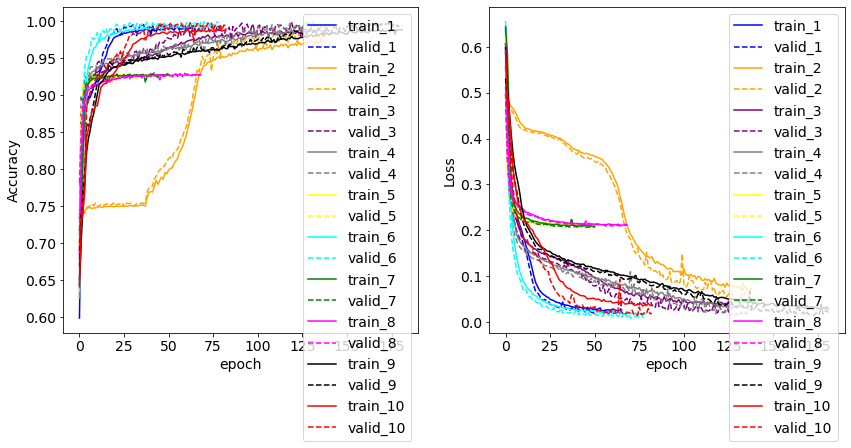

In [129]:
runs_10 = ['1','2','3','4','5','6','7','8','9','10']
cols_10 = cols = ['blue','orange','purple','grey','yellow','cyan','green','magenta','black',"red"]
plot_fits(fits_avg_glorot,runs_10,cols_10)

For the case of relu as an activation function, the glorotUniform seems to be performing the best in terms of accurcay and number of epochs. However, the case can be different for different activations functions. 

In [134]:
#HeUniform
init_al_H = 'he_uniform'
fits_avg_H = avg_test(4000,5,0.8,2,200,init_al_H)

Epoch 1/200
240/240 - 1s - loss: 0.5930 - accuracy: 0.6742 - val_loss: 0.4971 - val_accuracy: 0.7683 - 715ms/epoch - 3ms/step
Epoch 2/200
240/240 - 0s - loss: 0.4418 - accuracy: 0.8075 - val_loss: 0.3662 - val_accuracy: 0.8600 - 270ms/epoch - 1ms/step
Epoch 3/200
240/240 - 0s - loss: 0.3427 - accuracy: 0.8622 - val_loss: 0.2886 - val_accuracy: 0.8920 - 272ms/epoch - 1ms/step
Epoch 4/200
240/240 - 0s - loss: 0.2867 - accuracy: 0.8878 - val_loss: 0.2466 - val_accuracy: 0.9093 - 274ms/epoch - 1ms/step
Epoch 5/200
240/240 - 0s - loss: 0.2530 - accuracy: 0.9007 - val_loss: 0.2261 - val_accuracy: 0.9060 - 267ms/epoch - 1ms/step
Epoch 6/200
240/240 - 0s - loss: 0.2336 - accuracy: 0.9049 - val_loss: 0.2117 - val_accuracy: 0.9137 - 271ms/epoch - 1ms/step
Epoch 7/200
240/240 - 0s - loss: 0.2194 - accuracy: 0.9122 - val_loss: 0.2025 - val_accuracy: 0.9197 - 261ms/epoch - 1ms/step
Epoch 8/200
240/240 - 0s - loss: 0.2128 - accuracy: 0.9141 - val_loss: 0.1953 - val_accuracy: 0.9203 - 268ms/epoch - 1

Epoch 66/200
240/240 - 0s - loss: 0.1685 - accuracy: 0.9258 - val_loss: 0.1624 - val_accuracy: 0.9247 - 264ms/epoch - 1ms/step
Epoch 67/200
240/240 - 0s - loss: 0.1661 - accuracy: 0.9259 - val_loss: 0.1595 - val_accuracy: 0.9273 - 266ms/epoch - 1ms/step
Epoch 68/200
240/240 - 0s - loss: 0.1692 - accuracy: 0.9250 - val_loss: 0.1622 - val_accuracy: 0.9250 - 258ms/epoch - 1ms/step
Epoch 69/200
240/240 - 0s - loss: 0.1654 - accuracy: 0.9259 - val_loss: 0.1596 - val_accuracy: 0.9273 - 268ms/epoch - 1ms/step
Epoch 70/200
240/240 - 0s - loss: 0.1681 - accuracy: 0.9253 - val_loss: 0.1601 - val_accuracy: 0.9273 - 277ms/epoch - 1ms/step
Epoch 71/200
240/240 - 0s - loss: 0.1663 - accuracy: 0.9262 - val_loss: 0.1615 - val_accuracy: 0.9260 - 267ms/epoch - 1ms/step
Epoch 72/200
240/240 - 0s - loss: 0.1666 - accuracy: 0.9260 - val_loss: 0.1613 - val_accuracy: 0.9257 - 266ms/epoch - 1ms/step
Epoch 73/200
240/240 - 0s - loss: 0.1659 - accuracy: 0.9253 - val_loss: 0.1597 - val_accuracy: 0.9263 - 264ms/e

Epoch 56/200
240/240 - 0s - loss: 0.1869 - accuracy: 0.9188 - val_loss: 0.1706 - val_accuracy: 0.9273 - 256ms/epoch - 1ms/step
Epoch 57/200
240/240 - 0s - loss: 0.1836 - accuracy: 0.9208 - val_loss: 0.1690 - val_accuracy: 0.9293 - 259ms/epoch - 1ms/step
Epoch 58/200
240/240 - 0s - loss: 0.1871 - accuracy: 0.9208 - val_loss: 0.1671 - val_accuracy: 0.9310 - 259ms/epoch - 1ms/step
Epoch 59/200
240/240 - 0s - loss: 0.1854 - accuracy: 0.9179 - val_loss: 0.1741 - val_accuracy: 0.9250 - 258ms/epoch - 1ms/step
Epoch 60/200
240/240 - 0s - loss: 0.1895 - accuracy: 0.9196 - val_loss: 0.1667 - val_accuracy: 0.9317 - 257ms/epoch - 1ms/step
Epoch 61/200
240/240 - 0s - loss: 0.1825 - accuracy: 0.9232 - val_loss: 0.1635 - val_accuracy: 0.9360 - 259ms/epoch - 1ms/step
Epoch 62/200
240/240 - 0s - loss: 0.1836 - accuracy: 0.9202 - val_loss: 0.1639 - val_accuracy: 0.9357 - 259ms/epoch - 1ms/step
Epoch 63/200
240/240 - 0s - loss: 0.1795 - accuracy: 0.9223 - val_loss: 0.1634 - val_accuracy: 0.9317 - 256ms/e

Epoch 121/200
240/240 - 0s - loss: 0.1105 - accuracy: 0.9529 - val_loss: 0.0974 - val_accuracy: 0.9573 - 264ms/epoch - 1ms/step
Epoch 122/200
240/240 - 0s - loss: 0.1105 - accuracy: 0.9513 - val_loss: 0.0980 - val_accuracy: 0.9610 - 267ms/epoch - 1ms/step
Epoch 123/200
240/240 - 0s - loss: 0.1096 - accuracy: 0.9523 - val_loss: 0.0939 - val_accuracy: 0.9643 - 266ms/epoch - 1ms/step
Epoch 124/200
240/240 - 0s - loss: 0.1090 - accuracy: 0.9523 - val_loss: 0.0909 - val_accuracy: 0.9663 - 257ms/epoch - 1ms/step
Epoch 125/200
240/240 - 0s - loss: 0.1058 - accuracy: 0.9550 - val_loss: 0.1029 - val_accuracy: 0.9527 - 260ms/epoch - 1ms/step
Epoch 126/200
240/240 - 0s - loss: 0.1088 - accuracy: 0.9541 - val_loss: 0.0876 - val_accuracy: 0.9677 - 266ms/epoch - 1ms/step
Epoch 127/200
240/240 - 0s - loss: 0.1060 - accuracy: 0.9547 - val_loss: 0.0974 - val_accuracy: 0.9627 - 255ms/epoch - 1ms/step
Epoch 128/200
240/240 - 0s - loss: 0.1011 - accuracy: 0.9563 - val_loss: 0.0844 - val_accuracy: 0.9687 -

240/240 - 0s - loss: 0.4041 - accuracy: 0.8557 - val_loss: 0.3197 - val_accuracy: 0.8903 - 266ms/epoch - 1ms/step
Epoch 3/200
240/240 - 0s - loss: 0.3198 - accuracy: 0.8875 - val_loss: 0.2817 - val_accuracy: 0.9097 - 269ms/epoch - 1ms/step
Epoch 4/200
240/240 - 0s - loss: 0.2879 - accuracy: 0.9017 - val_loss: 0.2609 - val_accuracy: 0.9183 - 264ms/epoch - 1ms/step
Epoch 5/200
240/240 - 0s - loss: 0.2701 - accuracy: 0.9093 - val_loss: 0.2480 - val_accuracy: 0.9187 - 265ms/epoch - 1ms/step
Epoch 6/200
240/240 - 0s - loss: 0.2566 - accuracy: 0.9141 - val_loss: 0.2367 - val_accuracy: 0.9190 - 267ms/epoch - 1ms/step
Epoch 7/200
240/240 - 0s - loss: 0.2463 - accuracy: 0.9174 - val_loss: 0.2311 - val_accuracy: 0.9187 - 269ms/epoch - 1ms/step
Epoch 8/200
240/240 - 0s - loss: 0.2388 - accuracy: 0.9185 - val_loss: 0.2251 - val_accuracy: 0.9233 - 271ms/epoch - 1ms/step
Epoch 9/200
240/240 - 0s - loss: 0.2330 - accuracy: 0.9194 - val_loss: 0.2179 - val_accuracy: 0.9247 - 274ms/epoch - 1ms/step
Epoc

Epoch 67/200
240/240 - 0s - loss: 0.1706 - accuracy: 0.9272 - val_loss: 0.1666 - val_accuracy: 0.9240 - 283ms/epoch - 1ms/step
Epoch 68/200
240/240 - 0s - loss: 0.1720 - accuracy: 0.9244 - val_loss: 0.1630 - val_accuracy: 0.9260 - 281ms/epoch - 1ms/step
Epoch 69/200
240/240 - 0s - loss: 0.1713 - accuracy: 0.9241 - val_loss: 0.1620 - val_accuracy: 0.9270 - 277ms/epoch - 1ms/step
Epoch 70/200
240/240 - 0s - loss: 0.1705 - accuracy: 0.9232 - val_loss: 0.1717 - val_accuracy: 0.9233 - 277ms/epoch - 1ms/step
Epoch 71/200
240/240 - 0s - loss: 0.1711 - accuracy: 0.9226 - val_loss: 0.1603 - val_accuracy: 0.9277 - 280ms/epoch - 1ms/step
Epoch 72/200
240/240 - 0s - loss: 0.1721 - accuracy: 0.9212 - val_loss: 0.1612 - val_accuracy: 0.9273 - 274ms/epoch - 1ms/step
Epoch 73/200
240/240 - 0s - loss: 0.1697 - accuracy: 0.9234 - val_loss: 0.1617 - val_accuracy: 0.9250 - 272ms/epoch - 1ms/step
Epoch 74/200
240/240 - 0s - loss: 0.1698 - accuracy: 0.9229 - val_loss: 0.1602 - val_accuracy: 0.9280 - 271ms/e

Epoch 10/200
240/240 - 0s - loss: 0.2213 - accuracy: 0.9227 - val_loss: 0.2136 - val_accuracy: 0.9257 - 278ms/epoch - 1ms/step
Epoch 11/200
240/240 - 0s - loss: 0.2178 - accuracy: 0.9249 - val_loss: 0.2112 - val_accuracy: 0.9260 - 288ms/epoch - 1ms/step
Epoch 12/200
240/240 - 0s - loss: 0.2160 - accuracy: 0.9216 - val_loss: 0.2082 - val_accuracy: 0.9250 - 281ms/epoch - 1ms/step
Epoch 13/200
240/240 - 0s - loss: 0.2123 - accuracy: 0.9235 - val_loss: 0.2048 - val_accuracy: 0.9257 - 283ms/epoch - 1ms/step
Epoch 14/200
240/240 - 0s - loss: 0.2081 - accuracy: 0.9237 - val_loss: 0.2007 - val_accuracy: 0.9253 - 268ms/epoch - 1ms/step
Epoch 15/200
240/240 - 0s - loss: 0.2050 - accuracy: 0.9233 - val_loss: 0.1981 - val_accuracy: 0.9247 - 273ms/epoch - 1ms/step
Epoch 16/200
240/240 - 0s - loss: 0.2014 - accuracy: 0.9237 - val_loss: 0.1955 - val_accuracy: 0.9227 - 266ms/epoch - 1ms/step
Epoch 17/200
240/240 - 0s - loss: 0.1986 - accuracy: 0.9232 - val_loss: 0.1919 - val_accuracy: 0.9253 - 277ms/e

Epoch 8/200
240/240 - 0s - loss: 0.2327 - accuracy: 0.9175 - val_loss: 0.2095 - val_accuracy: 0.9300 - 272ms/epoch - 1ms/step
Epoch 9/200
240/240 - 0s - loss: 0.2201 - accuracy: 0.9181 - val_loss: 0.1990 - val_accuracy: 0.9280 - 280ms/epoch - 1ms/step
Epoch 10/200
240/240 - 0s - loss: 0.2049 - accuracy: 0.9213 - val_loss: 0.1944 - val_accuracy: 0.9230 - 274ms/epoch - 1ms/step
Epoch 11/200
240/240 - 0s - loss: 0.1976 - accuracy: 0.9243 - val_loss: 0.1756 - val_accuracy: 0.9337 - 269ms/epoch - 1ms/step
Epoch 12/200
240/240 - 0s - loss: 0.1844 - accuracy: 0.9252 - val_loss: 0.1640 - val_accuracy: 0.9367 - 268ms/epoch - 1ms/step
Epoch 13/200
240/240 - 0s - loss: 0.1757 - accuracy: 0.9293 - val_loss: 0.1517 - val_accuracy: 0.9417 - 262ms/epoch - 1ms/step
Epoch 14/200
240/240 - 0s - loss: 0.1627 - accuracy: 0.9332 - val_loss: 0.1351 - val_accuracy: 0.9493 - 266ms/epoch - 1ms/step
Epoch 15/200
240/240 - 0s - loss: 0.1416 - accuracy: 0.9421 - val_loss: 0.1151 - val_accuracy: 0.9570 - 264ms/epo

Epoch 73/200
240/240 - 0s - loss: 0.0288 - accuracy: 0.9883 - val_loss: 0.0219 - val_accuracy: 0.9917 - 264ms/epoch - 1ms/step
Epoch 74/200
240/240 - 0s - loss: 0.0287 - accuracy: 0.9892 - val_loss: 0.0212 - val_accuracy: 0.9930 - 273ms/epoch - 1ms/step
Epoch 75/200
240/240 - 0s - loss: 0.0333 - accuracy: 0.9876 - val_loss: 0.0243 - val_accuracy: 0.9893 - 265ms/epoch - 1ms/step
Epoch 76/200
240/240 - 0s - loss: 0.0274 - accuracy: 0.9890 - val_loss: 0.0187 - val_accuracy: 0.9947 - 269ms/epoch - 1ms/step
Epoch 77/200
240/240 - 0s - loss: 0.0273 - accuracy: 0.9895 - val_loss: 0.0279 - val_accuracy: 0.9873 - 286ms/epoch - 1ms/step
Epoch 78/200
240/240 - 0s - loss: 0.0283 - accuracy: 0.9888 - val_loss: 0.0166 - val_accuracy: 0.9970 - 327ms/epoch - 1ms/step
Epoch 79/200
240/240 - 0s - loss: 0.0282 - accuracy: 0.9885 - val_loss: 0.0183 - val_accuracy: 0.9937 - 290ms/epoch - 1ms/step
Epoch 80/200
240/240 - 0s - loss: 0.0280 - accuracy: 0.9893 - val_loss: 0.0176 - val_accuracy: 0.9947 - 278ms/e

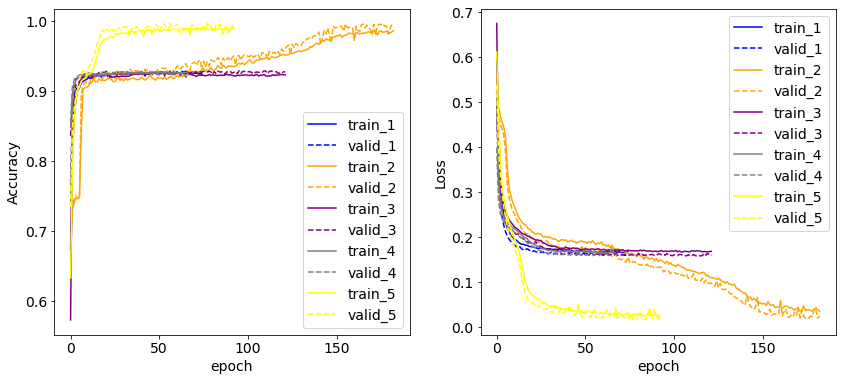

In [135]:
plot_fits(fits_avg_H,runs,cols)

In [40]:
fits_avg_H = avg_test(4000,5,0.8,2,200,'he_normal','relu')
#num_samp,rounds,perc,L_dim,nepochs,initializer_func,activation='relu'

Epoch 1/200
64/64 - 1s - loss: 0.6572 - accuracy: 0.5553 - val_loss: 0.6373 - val_accuracy: 0.5562 - 580ms/epoch - 9ms/step
Epoch 2/200
64/64 - 0s - loss: 0.6239 - accuracy: 0.5928 - val_loss: 0.6052 - val_accuracy: 0.6300 - 109ms/epoch - 2ms/step
Epoch 3/200
64/64 - 0s - loss: 0.5904 - accuracy: 0.6569 - val_loss: 0.5738 - val_accuracy: 0.6438 - 136ms/epoch - 2ms/step
Epoch 4/200
64/64 - 0s - loss: 0.5608 - accuracy: 0.6928 - val_loss: 0.5504 - val_accuracy: 0.6725 - 163ms/epoch - 3ms/step
Epoch 5/200
64/64 - 0s - loss: 0.5385 - accuracy: 0.7081 - val_loss: 0.5307 - val_accuracy: 0.7000 - 157ms/epoch - 2ms/step
Epoch 6/200
64/64 - 0s - loss: 0.5224 - accuracy: 0.7300 - val_loss: 0.5122 - val_accuracy: 0.7312 - 153ms/epoch - 2ms/step
Epoch 7/200
64/64 - 0s - loss: 0.5042 - accuracy: 0.7431 - val_loss: 0.4982 - val_accuracy: 0.7412 - 135ms/epoch - 2ms/step
Epoch 8/200
64/64 - 0s - loss: 0.4853 - accuracy: 0.7572 - val_loss: 0.4809 - val_accuracy: 0.7500 - 138ms/epoch - 2ms/step
Epoch 9/

Epoch 67/200
64/64 - 0s - loss: 0.1696 - accuracy: 0.9328 - val_loss: 0.1905 - val_accuracy: 0.9125 - 103ms/epoch - 2ms/step
Epoch 68/200
64/64 - 0s - loss: 0.1691 - accuracy: 0.9334 - val_loss: 0.1866 - val_accuracy: 0.9175 - 107ms/epoch - 2ms/step
Epoch 69/200
64/64 - 0s - loss: 0.1690 - accuracy: 0.9325 - val_loss: 0.1878 - val_accuracy: 0.9175 - 106ms/epoch - 2ms/step
Epoch 70/200
64/64 - 0s - loss: 0.1677 - accuracy: 0.9322 - val_loss: 0.1864 - val_accuracy: 0.9150 - 101ms/epoch - 2ms/step
Epoch 71/200
64/64 - 0s - loss: 0.1667 - accuracy: 0.9334 - val_loss: 0.1872 - val_accuracy: 0.9112 - 103ms/epoch - 2ms/step
Epoch 72/200
64/64 - 0s - loss: 0.1663 - accuracy: 0.9344 - val_loss: 0.1847 - val_accuracy: 0.9162 - 100ms/epoch - 2ms/step
Epoch 73/200
64/64 - 0s - loss: 0.1689 - accuracy: 0.9319 - val_loss: 0.1870 - val_accuracy: 0.9137 - 97ms/epoch - 2ms/step
Epoch 74/200
64/64 - 0s - loss: 0.1680 - accuracy: 0.9303 - val_loss: 0.1845 - val_accuracy: 0.9150 - 96ms/epoch - 1ms/step
Ep

Epoch 24/200
64/64 - 0s - loss: 0.4442 - accuracy: 0.8041 - val_loss: 0.4263 - val_accuracy: 0.8087 - 100ms/epoch - 2ms/step
Epoch 25/200
64/64 - 0s - loss: 0.4515 - accuracy: 0.8025 - val_loss: 0.4257 - val_accuracy: 0.8075 - 99ms/epoch - 2ms/step
Epoch 26/200
64/64 - 0s - loss: 0.4495 - accuracy: 0.8006 - val_loss: 0.4270 - val_accuracy: 0.8100 - 105ms/epoch - 2ms/step
Epoch 27/200
64/64 - 0s - loss: 0.4404 - accuracy: 0.8087 - val_loss: 0.4203 - val_accuracy: 0.8138 - 98ms/epoch - 2ms/step
Epoch 28/200
64/64 - 0s - loss: 0.4435 - accuracy: 0.8066 - val_loss: 0.4177 - val_accuracy: 0.8100 - 97ms/epoch - 2ms/step
Epoch 29/200
64/64 - 0s - loss: 0.4395 - accuracy: 0.8103 - val_loss: 0.4133 - val_accuracy: 0.8150 - 98ms/epoch - 2ms/step
Epoch 30/200
64/64 - 0s - loss: 0.4293 - accuracy: 0.8122 - val_loss: 0.4208 - val_accuracy: 0.8125 - 97ms/epoch - 2ms/step
Epoch 31/200
64/64 - 0s - loss: 0.4284 - accuracy: 0.8172 - val_loss: 0.4090 - val_accuracy: 0.8150 - 96ms/epoch - 1ms/step
Epoch 

Epoch 90/200
64/64 - 0s - loss: 0.1698 - accuracy: 0.9325 - val_loss: 0.1679 - val_accuracy: 0.9337 - 95ms/epoch - 1ms/step
Epoch 91/200
64/64 - 0s - loss: 0.1665 - accuracy: 0.9362 - val_loss: 0.1654 - val_accuracy: 0.9362 - 94ms/epoch - 1ms/step
Epoch 92/200
64/64 - 0s - loss: 0.1723 - accuracy: 0.9300 - val_loss: 0.1633 - val_accuracy: 0.9350 - 94ms/epoch - 1ms/step
Epoch 93/200
64/64 - 0s - loss: 0.1742 - accuracy: 0.9328 - val_loss: 0.1667 - val_accuracy: 0.9312 - 93ms/epoch - 1ms/step
Epoch 94/200
64/64 - 0s - loss: 0.1679 - accuracy: 0.9341 - val_loss: 0.1796 - val_accuracy: 0.9175 - 97ms/epoch - 2ms/step
Epoch 95/200
64/64 - 0s - loss: 0.1638 - accuracy: 0.9366 - val_loss: 0.1638 - val_accuracy: 0.9337 - 96ms/epoch - 1ms/step
Epoch 96/200
64/64 - 0s - loss: 0.1658 - accuracy: 0.9369 - val_loss: 0.1603 - val_accuracy: 0.9388 - 95ms/epoch - 1ms/step
Epoch 97/200
64/64 - 0s - loss: 0.1696 - accuracy: 0.9294 - val_loss: 0.1611 - val_accuracy: 0.9337 - 116ms/epoch - 2ms/step
Epoch 9

Epoch 156/200
64/64 - 0s - loss: 0.1114 - accuracy: 0.9531 - val_loss: 0.1102 - val_accuracy: 0.9488 - 96ms/epoch - 1ms/step
Epoch 157/200
64/64 - 0s - loss: 0.1082 - accuracy: 0.9538 - val_loss: 0.1077 - val_accuracy: 0.9513 - 94ms/epoch - 1ms/step
Epoch 158/200
64/64 - 0s - loss: 0.1062 - accuracy: 0.9544 - val_loss: 0.1064 - val_accuracy: 0.9550 - 96ms/epoch - 1ms/step
Epoch 159/200
64/64 - 0s - loss: 0.1046 - accuracy: 0.9563 - val_loss: 0.1033 - val_accuracy: 0.9550 - 95ms/epoch - 1ms/step
Epoch 160/200
64/64 - 0s - loss: 0.1057 - accuracy: 0.9547 - val_loss: 0.1038 - val_accuracy: 0.9613 - 98ms/epoch - 2ms/step
Epoch 161/200
64/64 - 0s - loss: 0.1048 - accuracy: 0.9563 - val_loss: 0.1092 - val_accuracy: 0.9488 - 93ms/epoch - 1ms/step
Epoch 162/200
64/64 - 0s - loss: 0.1065 - accuracy: 0.9550 - val_loss: 0.1049 - val_accuracy: 0.9525 - 96ms/epoch - 2ms/step
Epoch 163/200
64/64 - 0s - loss: 0.1038 - accuracy: 0.9500 - val_loss: 0.1003 - val_accuracy: 0.9550 - 97ms/epoch - 2ms/step


Epoch 22/200
64/64 - 0s - loss: 0.3748 - accuracy: 0.8556 - val_loss: 0.3799 - val_accuracy: 0.8612 - 92ms/epoch - 1ms/step
Epoch 23/200
64/64 - 0s - loss: 0.3572 - accuracy: 0.8703 - val_loss: 0.3495 - val_accuracy: 0.8813 - 93ms/epoch - 1ms/step
Epoch 24/200
64/64 - 0s - loss: 0.3299 - accuracy: 0.8953 - val_loss: 0.3097 - val_accuracy: 0.9125 - 95ms/epoch - 1ms/step
Epoch 25/200
64/64 - 0s - loss: 0.2940 - accuracy: 0.9122 - val_loss: 0.2734 - val_accuracy: 0.9225 - 94ms/epoch - 1ms/step
Epoch 26/200
64/64 - 0s - loss: 0.2683 - accuracy: 0.9216 - val_loss: 0.2581 - val_accuracy: 0.9262 - 95ms/epoch - 1ms/step
Epoch 27/200
64/64 - 0s - loss: 0.2534 - accuracy: 0.9250 - val_loss: 0.2403 - val_accuracy: 0.9200 - 93ms/epoch - 1ms/step
Epoch 28/200
64/64 - 0s - loss: 0.2464 - accuracy: 0.9219 - val_loss: 0.2324 - val_accuracy: 0.9212 - 92ms/epoch - 1ms/step
Epoch 29/200
64/64 - 0s - loss: 0.2387 - accuracy: 0.9206 - val_loss: 0.2204 - val_accuracy: 0.9187 - 90ms/epoch - 1ms/step
Epoch 30

Epoch 88/200
64/64 - 0s - loss: 0.1684 - accuracy: 0.9362 - val_loss: 0.1633 - val_accuracy: 0.9200 - 103ms/epoch - 2ms/step
Epoch 89/200
64/64 - 0s - loss: 0.1617 - accuracy: 0.9400 - val_loss: 0.1609 - val_accuracy: 0.9275 - 101ms/epoch - 2ms/step
Epoch 90/200
64/64 - 0s - loss: 0.1610 - accuracy: 0.9381 - val_loss: 0.1633 - val_accuracy: 0.9275 - 172ms/epoch - 3ms/step
Epoch 91/200
64/64 - 0s - loss: 0.1628 - accuracy: 0.9381 - val_loss: 0.1605 - val_accuracy: 0.9287 - 177ms/epoch - 3ms/step
Epoch 92/200
64/64 - 0s - loss: 0.1629 - accuracy: 0.9331 - val_loss: 0.1646 - val_accuracy: 0.9275 - 227ms/epoch - 4ms/step
Epoch 93/200
64/64 - 0s - loss: 0.1687 - accuracy: 0.9353 - val_loss: 0.1606 - val_accuracy: 0.9250 - 226ms/epoch - 4ms/step
Epoch 94/200
64/64 - 0s - loss: 0.1614 - accuracy: 0.9381 - val_loss: 0.1601 - val_accuracy: 0.9250 - 149ms/epoch - 2ms/step
Epoch 95/200
64/64 - 0s - loss: 0.1626 - accuracy: 0.9362 - val_loss: 0.1610 - val_accuracy: 0.9275 - 114ms/epoch - 2ms/step


Epoch 41/200
64/64 - 0s - loss: 0.1904 - accuracy: 0.9162 - val_loss: 0.1986 - val_accuracy: 0.9087 - 97ms/epoch - 2ms/step
Epoch 42/200
64/64 - 0s - loss: 0.1900 - accuracy: 0.9203 - val_loss: 0.1976 - val_accuracy: 0.9075 - 88ms/epoch - 1ms/step
Epoch 43/200
64/64 - 0s - loss: 0.1878 - accuracy: 0.9191 - val_loss: 0.1960 - val_accuracy: 0.9087 - 90ms/epoch - 1ms/step
Epoch 44/200
64/64 - 0s - loss: 0.1912 - accuracy: 0.9162 - val_loss: 0.1943 - val_accuracy: 0.9100 - 90ms/epoch - 1ms/step
Epoch 45/200
64/64 - 0s - loss: 0.1868 - accuracy: 0.9209 - val_loss: 0.1946 - val_accuracy: 0.9100 - 89ms/epoch - 1ms/step
Epoch 46/200
64/64 - 0s - loss: 0.1854 - accuracy: 0.9212 - val_loss: 0.1919 - val_accuracy: 0.9125 - 95ms/epoch - 1ms/step
Epoch 47/200
64/64 - 0s - loss: 0.1863 - accuracy: 0.9203 - val_loss: 0.1990 - val_accuracy: 0.9025 - 106ms/epoch - 2ms/step
Epoch 48/200
64/64 - 0s - loss: 0.1807 - accuracy: 0.9228 - val_loss: 0.1907 - val_accuracy: 0.9112 - 94ms/epoch - 1ms/step
Epoch 4

Epoch 17/200
64/64 - 0s - loss: 0.2338 - accuracy: 0.9275 - val_loss: 0.2576 - val_accuracy: 0.9200 - 128ms/epoch - 2ms/step
Epoch 18/200
64/64 - 0s - loss: 0.2259 - accuracy: 0.9259 - val_loss: 0.2549 - val_accuracy: 0.9125 - 116ms/epoch - 2ms/step
Epoch 19/200
64/64 - 0s - loss: 0.2294 - accuracy: 0.9269 - val_loss: 0.2534 - val_accuracy: 0.9112 - 99ms/epoch - 2ms/step
Epoch 20/200
64/64 - 0s - loss: 0.2240 - accuracy: 0.9287 - val_loss: 0.2519 - val_accuracy: 0.9112 - 92ms/epoch - 1ms/step
Epoch 21/200
64/64 - 0s - loss: 0.2234 - accuracy: 0.9291 - val_loss: 0.2527 - val_accuracy: 0.9125 - 139ms/epoch - 2ms/step
Epoch 22/200
64/64 - 0s - loss: 0.2210 - accuracy: 0.9306 - val_loss: 0.2503 - val_accuracy: 0.9100 - 154ms/epoch - 2ms/step
Epoch 23/200
64/64 - 0s - loss: 0.2188 - accuracy: 0.9281 - val_loss: 0.2493 - val_accuracy: 0.9212 - 158ms/epoch - 2ms/step
Epoch 24/200
64/64 - 0s - loss: 0.2194 - accuracy: 0.9284 - val_loss: 0.2484 - val_accuracy: 0.9212 - 149ms/epoch - 2ms/step
Ep

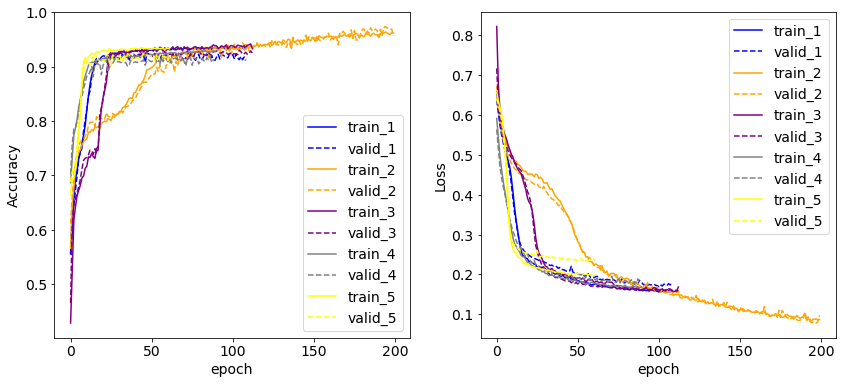

In [41]:
runs = ['1','2','3','4','5']
cols = ['blue','orange','purple','grey','yellow']
plot_fits(fits_avg_H,runs,cols)

In [48]:
N = 4000
N_train = int(4000*0.8)

x_test,y_test = generate_data(N)
x_train = x_test[0:N_train]
y_train = y_test[0:N_train]
x_valid = x_test[N_train:]
y_valid = y_test[N_train:]
x_train, x_valid = Rescale(x_train),Rescale(x_valid)
model_gridsearch = KerasClassifier(model=compile_model,
                                  epochs=200,
                                  batch_size = 50,
                                  verbose=2)

#L = 2
#hidden_layers = 2
#drop_out = 0.2
#opti = 'adam'
initializer = ['glorot_uniform','glorot_normal','he_uniform','he_nromal']
activation = ["relu","sigmoid"]
#create = create_model

#L=2,hidden_layers=2,activation_func='relu',drop_out=0.2,opti='adam',init_al='glorot_uniform', create = create_model
param_grid = dict(init_al = initializer,activation_func = activation)

grid = GridSearchCV(estimator = model_gridsearch, param_grid = param_grid, n_jobs=1, cv = 4)

In [49]:
grid_result = grid.fit(x_train,y_train)

ValueError: Invalid parameter activation_func for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(activation_func=relu)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
runs = ['1','2','3','4','5']
plot_fits(fits_uniform,runs,cols)